# Проект «Банки — Анализ оттока клиентов»

Заказчик – банк «Метанпром», который располагается в Ярославле и областных городах: Ростов Великий и Рыбинск. 

Одна из проблем любого бизнеса, в том числе и банка – отток клиентов. Заказчик хочет заранее знать, какие клиенты более склонны к прекращению обслуживания в банке, чтобы иметь возможность предотвратить отток.

**Задача:** на основе анализа данных выявить клиентов с риском оттока, подготовить план действий по их удержанию для отдела продуктового маркетинга.

А именно:
* сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* спрогнозировать вероятность оттока;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
> 1. выделить целевые группы клиентов;
> 2. предложить меры по снижению оттока;
> 3. определить другие особенности взаимодействия с клиентами.

Итогом исследования должна стать презентация с аргументированными рекомендациями и визуализациями в формате PDF, а также интерактивный дашборд следующего вида:
* Диаграмма, отображающаю количество пользователей по городам
* Индикатор количества пользователей
* Фильтр дашборда по полу

**Описание датасета:**

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

Колонки:

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.

## Обзор данных


- Загрузка данных
- Изучение общей информации о датасете
- Просмотр отсутствующих значений, дубликатов, уникальных значений
- Вывод по шагу

### Загрузка данных

In [1]:
# импорт библиотек и модулей
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
import scipy.stats as st

from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, \
    recall_score, roc_auc_score, silhouette_score, f1_score
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from scipy.cluster.hierarchy import dendrogram, linkage


# настройка параметров отображения
custom_params = {'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(style='ticks', rc=custom_params)
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', '{:.2f}'.format)


In [2]:
# загрузка и чтение размера датасета
file = 'https://code.s3.yandex.net/datasets/bank_dataset.csv'
df = pd.read_csv(file)
df.shape

(10000, 12)

### Изучение общей информации о датасете

In [3]:
# просмотр информации о данных
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


### Просмотр отсутствующих значений, дубликатов, уникальных значений

In [4]:
# проверка отсутствующих значений 
df.isnull().sum()

userid                 0
score                  0
City                   0
Gender                 0
Age                    0
Objects                0
Balance             3617
Products               0
CreditCard             0
Loyalty                0
estimated_salary       0
Churn                  0
dtype: int64

Найдены отсутствующие значения в столбце `Balance`. Процент таких значений довольно большой - 36%. На этапе продобработки решим, как лучше поступить с ними.

In [5]:
# проверка на явные дубликаты
df.duplicated().sum()

0

Явных дубликатов строк не обнаружено.

In [6]:
# просмотр количества уникальных значений
df.nunique()

userid              10000
score                 460
City                    3
Gender                  2
Age                    70
Objects                11
Balance              6381
Products                4
CreditCard              2
Loyalty                 2
estimated_salary     9999
Churn                   2
dtype: int64

В датасете присутствуют как непрерывные величины, так и дискретные.

Проверим строковые данные, чтобы убедиться, что там нет дублей или некорректного написания, которое может привести к неявным дублям.

In [7]:
# просмотр уникальных значений строковых типов
print(df['City'].unique())
print(df['Gender'].unique())

['Ярославль' 'Рыбинск' 'Ростов Великий']
['Ж' 'М']


### Вывод по шагу

В датафрейме 10 000 записей и 12 столбцов, среди которых 11 признаков и целевая переменная – показатель оттока. 

Явных дубликатов строк не обнаружено.

В датасете присутствуют как дискретные (категориальные), так и непрерывные (количественные) значения.

Найденные недочеты:
- Названия столбцов можно привести к `lowercase` для удобства работы и лучшей читабельности;
- Строковый столбец `Gender` можно привести к целочисленному типу `int` для более удобных расчетов;
- В столбце `Balance` присутствует большая доля пропущенных значений, причина неизвестна, нужно постараться определить, чем вызваны эти пропуски;
- Признаки с непрерывными величинами можно категоризировать для удобной сегментации клиентов.



---

## Предобработка данных


- Замена именований столбцов
- Замена типов данных
- Категоризация данных
- Проверка данных на противоречивость
- Обработка отсутствующих значений
- Вывод по шагу

### Замена именований столбцов

In [8]:
# замена именования столбцов
df.rename(str.lower, axis=1, inplace=True)
print('Новые названия столбцов:', df.columns)

Новые названия столбцов: Index(['userid', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'creditcard', 'loyalty', 'estimated_salary', 'churn'],
      dtype='object')


### Замена типов данных

In [9]:
# замена строкового типа данных на категориальный численный
print('До замены в gender, значения:', df['gender'].unique(), df['gender'].dtype)
df['gender'] = df['gender'].replace({'М':1, 'Ж':0})
print('После замены в gender, значения:', df['gender'].unique(), df['gender'].dtype)

До замены в gender, значения: ['Ж' 'М'] object
После замены в gender, значения: [0 1] int64


### Категоризация данных

Для более удобного анализа портретов, сгруппируем дискретные признаки, присвоив им категории.

In [10]:
# создание копии датасета
df_grouped = df.copy(deep=True)


# создание списков лейблов и границ диапазонов денежных средств
money_labels = ['<15', '15-50', '50-100', '100-200', '>200']
money_bins = [0, 15000, 50000, 100000, 200000, 1000000]

# категоризация для признаков с балансом денежных средств
df_grouped['balance_group'] = pd.cut(df_grouped['balance'],
                       bins=money_bins,
                       labels=money_labels)

# категоризация для признаков с балансом денежных средств
df_grouped['estimated_salary_group'] = pd.cut(df_grouped['estimated_salary'],
                       bins=money_bins,
                       labels=money_labels)


# создание списков лейблов и границ диапазонов кредитного рейтинга
"""
    Возвращает группу по значению ПКР, используя правила шкалы 300-850:
    300 — 500 баллов: низкий, получить кредит очень сложно.
    500 — 600 баллов: средний, получить кредит будет непросто.
    600 — 700 баллов: хороший, получить кредит будет довольно просто.
    700 — 850 баллов: очень хороший. 
    """
score_labels = ['низкий', 'средний', 'хороший', 'очень хороший']
score_bins = [0, 500, 600, 700, 850]

# категоризация для признаков с балансом денежных средств
df_grouped['score_group'] = pd.cut(df_grouped['score'],
                       bins=score_bins,
                       labels=score_labels)

In [11]:
# категоризация для признака age

# определение функции для присвоения категории
def age_group(gender, age):
    """
    Возвращает группу по значению возраста, используя правила:
    - до 18
    - 18-35 
    - 36-62(ж)/65(м)
    - старше 62(ж)/65(м)
    """

    if 18 > age:
        return 'ребенок'
    elif age <= 35:
        return 'молодой'
    elif 36 <= age < 65 and gender == 1:
        return 'взрослый'
    elif 36 <= age < 62:
        return 'взрослый' 
    return 'пенсионер'


# добавление нового столбца с рассчитанными данными
df_grouped['age_group'] = df_grouped.apply(lambda x: age_group(x['gender'], x['age']), axis=1)

In [12]:
# проверка корректности расчетов категорий для мужчин от 62
df_grouped.query('gender == 1 and age >= 62').head()

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,balance_group,estimated_salary_group,score_group,age_group
181,15832405,510,Ярославль,1,65,2,NaN,2,1,1,48071.61,0,NaN,15-50,средний,пенсионер
230,15851209,673,Ярославль,1,72,1,NaN,2,0,1,111981.19,0,NaN,100-200,хороший,пенсионер
243,15638911,659,Ростов Великий,1,67,6,117411.60,1,1,1,45071.09,1,100-200,15-50,хороший,пенсионер
276,15737192,756,Ярославль,1,62,3,NaN,1,1,1,11199.04,1,NaN,<15,очень хороший,взрослый
364,15719451,640,Ярославль,1,68,9,NaN,2,1,1,199493.38,0,NaN,100-200,хороший,пенсионер


### Проверка данных на противоречивость

Проверим данные на возможные противоречия.

Кандидаты:
- одновременное нахождение в `churn` и `loyalty`
- высокий `score_group` с низким показателем `estimated_salary_group`
- возраст 18 лет и высокий кредитный рейтинг

In [13]:
# пересечение churn и loyalty
len(df_grouped.query('loyalty == 1 and churn == 1'))

735

735 клиентов уже находятся в статусе оттока, но всё еще пользуются банком.

Такое может быть, так как срок расторжения банковского договора составляет 60 дней, в течение которых клиенты могут продолжать пользоваться продуктами банка.

In [14]:
# пересечение высокий `score_group` с низким показателем `estimated_salary_group`
len(df_grouped.query('estimated_salary_group == "<15" and \
                      score_group == "очень хороший"'))


219

219 клиентов имеют очень хороший кредитный рейтинг, при этом рассчетную заработную плату менее 15000.

Если речь идет о рублях, то это ниже МРОТ. Сомнительно, что клиент может получить высокий балл рейтинга при таких доходах. Но у нас нет данных, за какой период собрана информация о расчетной заработной плате и какова кредитная история клиента, имеющейся информации недостаточно, чтобы сделать вывод. 

Так как число подозрительных для нас данных незначительное, то оставим их без изменения.

In [15]:
# возраст 18 лет и высокий кредитный рейтинг
len(df_grouped.query('age == 18 and score_group == "очень хороший"'))

9

Всего 9 восемнадцатилетних клиентов, но с подозрительными параметрами: по закону кредиты можно брать с 18 лет, то есть у них пока не может быть кредитной истории, тем более с таким высоким рейтингом.

Стоит передать в банк информацию на проверку этих клиентов, возможно где-то в их данных закралась ошибка.

Нам же эти 9 строк не помешают в анализе, тоже оставляем.

### Обработка отсутствующих значений

Попробуем определить, что за данные скрываются в 3617 строках с пропущенными значениями баланса. 

Необходимо посмотреть на распределения остальных признаков в группе клиентов с пропусками и попробовать предположить, по какому механизму пропуски сформировались (MCAR, MAR, MNAR) - от этого будет зависеть то, как мы их обработаем.

In [16]:
# создание датасета с отсутствующими данными о балансе
nan_balance = df_grouped[df_grouped['balance'].isna()]

# корелляция целевого столбца с остальными
df_grouped.corr()['balance'][:-1]

userid             -0.01
score              -0.00
gender              0.03
age                -0.01
objects             0.01
balance             1.00
products           -0.00
creditcard          0.01
loyalty            -0.02
estimated_salary   -0.00
Name: balance, dtype: float64

Не найдено даже слабой корреляции какого-либо признака со столбцом Баланс. 

In [17]:
# посмотрим на характеристики признаков
nan_balance.drop(columns='balance').describe().T

,count,mean,std,min,25%,50%,75%,max
userid,3617.00,15734685.59,71947.49,15608442.00,15672255.00,15736083.00,15796286.00,15858100.00
score,3617.00,649.45,96.16,350.00,583.00,651.00,717.00,850.00
gender,3617.00,0.54,0.50,0.00,0.00,1.00,1.00,1.00
age,3617.00,38.43,10.49,18.00,31.00,37.00,43.00,88.00
objects,3617.00,5.07,2.86,0.00,3.00,5.00,7.00,10.00
products,3617.00,1.78,0.50,1.00,1.00,2.00,2.00,4.00
creditcard,3617.00,0.72,0.45,0.00,0.00,1.00,1.00,1.00
loyalty,3617.00,0.52,0.50,0.00,0.00,1.00,1.00,1.00
estimated_salary,3617.00,98983.56,57730.83,90.07,49506.82,98618.79,148330.97,199992.48
churn,3617.00,0.14,0.35,0.00,0.00,0.00,0.00,1.00


In [18]:
# посмотрим на статистику по городам
nan_balance.groupby('city').agg({'userid':'count'})

,userid
city,
Рыбинск,1199
Ярославль,2418


В срезе есть клиенты от 18 до 88 лет.

Показатель оттока всего 14%.

В группу входят только клиенты из Рыбинска и Ярославля, исключая Ростов Великий.

Можно было бы заполнить нулями, если бы мы были уверены, что это техническая ошибка и NaN значит `0`. Но таких данных у нас нет, а заполнение нулями в таком количестве сдвинет средние показатели и испортит качество анализа. Кроме того, количество данных слишком велико.

На данном этапе мы оставим пропуски без изменений, а при работе с моделями машинного обучения исключим их из датасета. 

Вероятно, пропуски вызваны какой-то технической ошибкой – следует передать  информацию заказчику для проверки и исключения подобных случаев в дальнейшем.


### Вывод по шагу

Данные обработаны – столбцы переименованы, заменен строковый тип данных на численный, проверена возможность замены пропущенных значений, проведена категоризация непрерывных значений и проверка на противоречивость в данных.

-----

## Исследовательский анализ данных


- Описательные статистики
- Визуализация распределений признаков
- Очистка от выбросов
- Тепловая матрица корреляций
- Сегментация пользователей (с оттоком и без)
- Изучение сегментов клиентов по параметрам: город, возраст, пол; портреты пользователей
- Описание основных признаков, наиболее сильно влияющие на отток
- Вывод по шагу

### Описательные статистики


Выведем портрет среднестатистического клиента по всему датасету:

In [19]:
# вывод статистик датасета
df_grouped.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,10000.00,15733676.57,71936.19,15608437.00,15671264.25,15733474.00,15795969.75,15858426.00
score,10000.00,650.53,96.65,350.00,584.00,652.00,718.00,850.00
gender,10000.00,0.55,0.50,0.00,0.00,1.00,1.00,1.00
age,10000.00,38.92,10.49,18.00,32.00,37.00,44.00,92.00
objects,10000.00,5.01,2.89,0.00,3.00,5.00,7.00,10.00
balance,6383.00,119827.49,30095.06,3768.69,100181.98,119839.69,139512.29,250898.09
products,10000.00,1.53,0.58,1.00,1.00,1.00,2.00,4.00
creditcard,10000.00,0.71,0.46,0.00,0.00,1.00,1.00,1.00
loyalty,10000.00,0.52,0.50,0.00,0.00,1.00,1.00,1.00
estimated_salary,10000.00,100090.24,57510.49,11.58,51002.11,100193.91,149388.25,199992.48


По категориальным признакам (средние):
- 55% клиентов – мужчины
- 52% клиентов активны
- 20% клиентов уже расторгли договор (ушли из банка, находятся в оттоке)
- 71% имеют кредитную карту


По непрерывным признакам:
- Возраст клиентов банка: от 18 до 92 лет. Самая многочисленная группа – от 32 до 44 лет. Медиана возраста – 37 лет;
- Объекты в собственности: у клиента может быть от 0 до 10 объектов, большинство имеют 3-7, по медиане 5;
- Баллы кредитного скоринга: возможны значения от 350 до 850, самый объемный диапазон от 584 до 718. Медианный балл 652 ("хороший");
- Баланс по медиане около 120000 уе.
- Расчетная заработная плата по медиане около 100000 уе.

### Визуализация распределений признаков

Для удобства фильтрации по признакам, создадим списки с именованиями столбцов, с которыми будем работать далее.

In [20]:
# создание списков столбцов по типу признака

# количественные
cont_metrics = ['score', 'age', 'balance',
       'estimated_salary', 'churn', 'city']

# категориальные
cat_metrics = ['gender', 'creditcard', 'loyalty', 'products', 'objects', \
              'city', 'balance_group', 'estimated_salary_group',\
              'age_group', 'score_group', 'churn']


Выведем распределение количественных признаков в цикле:

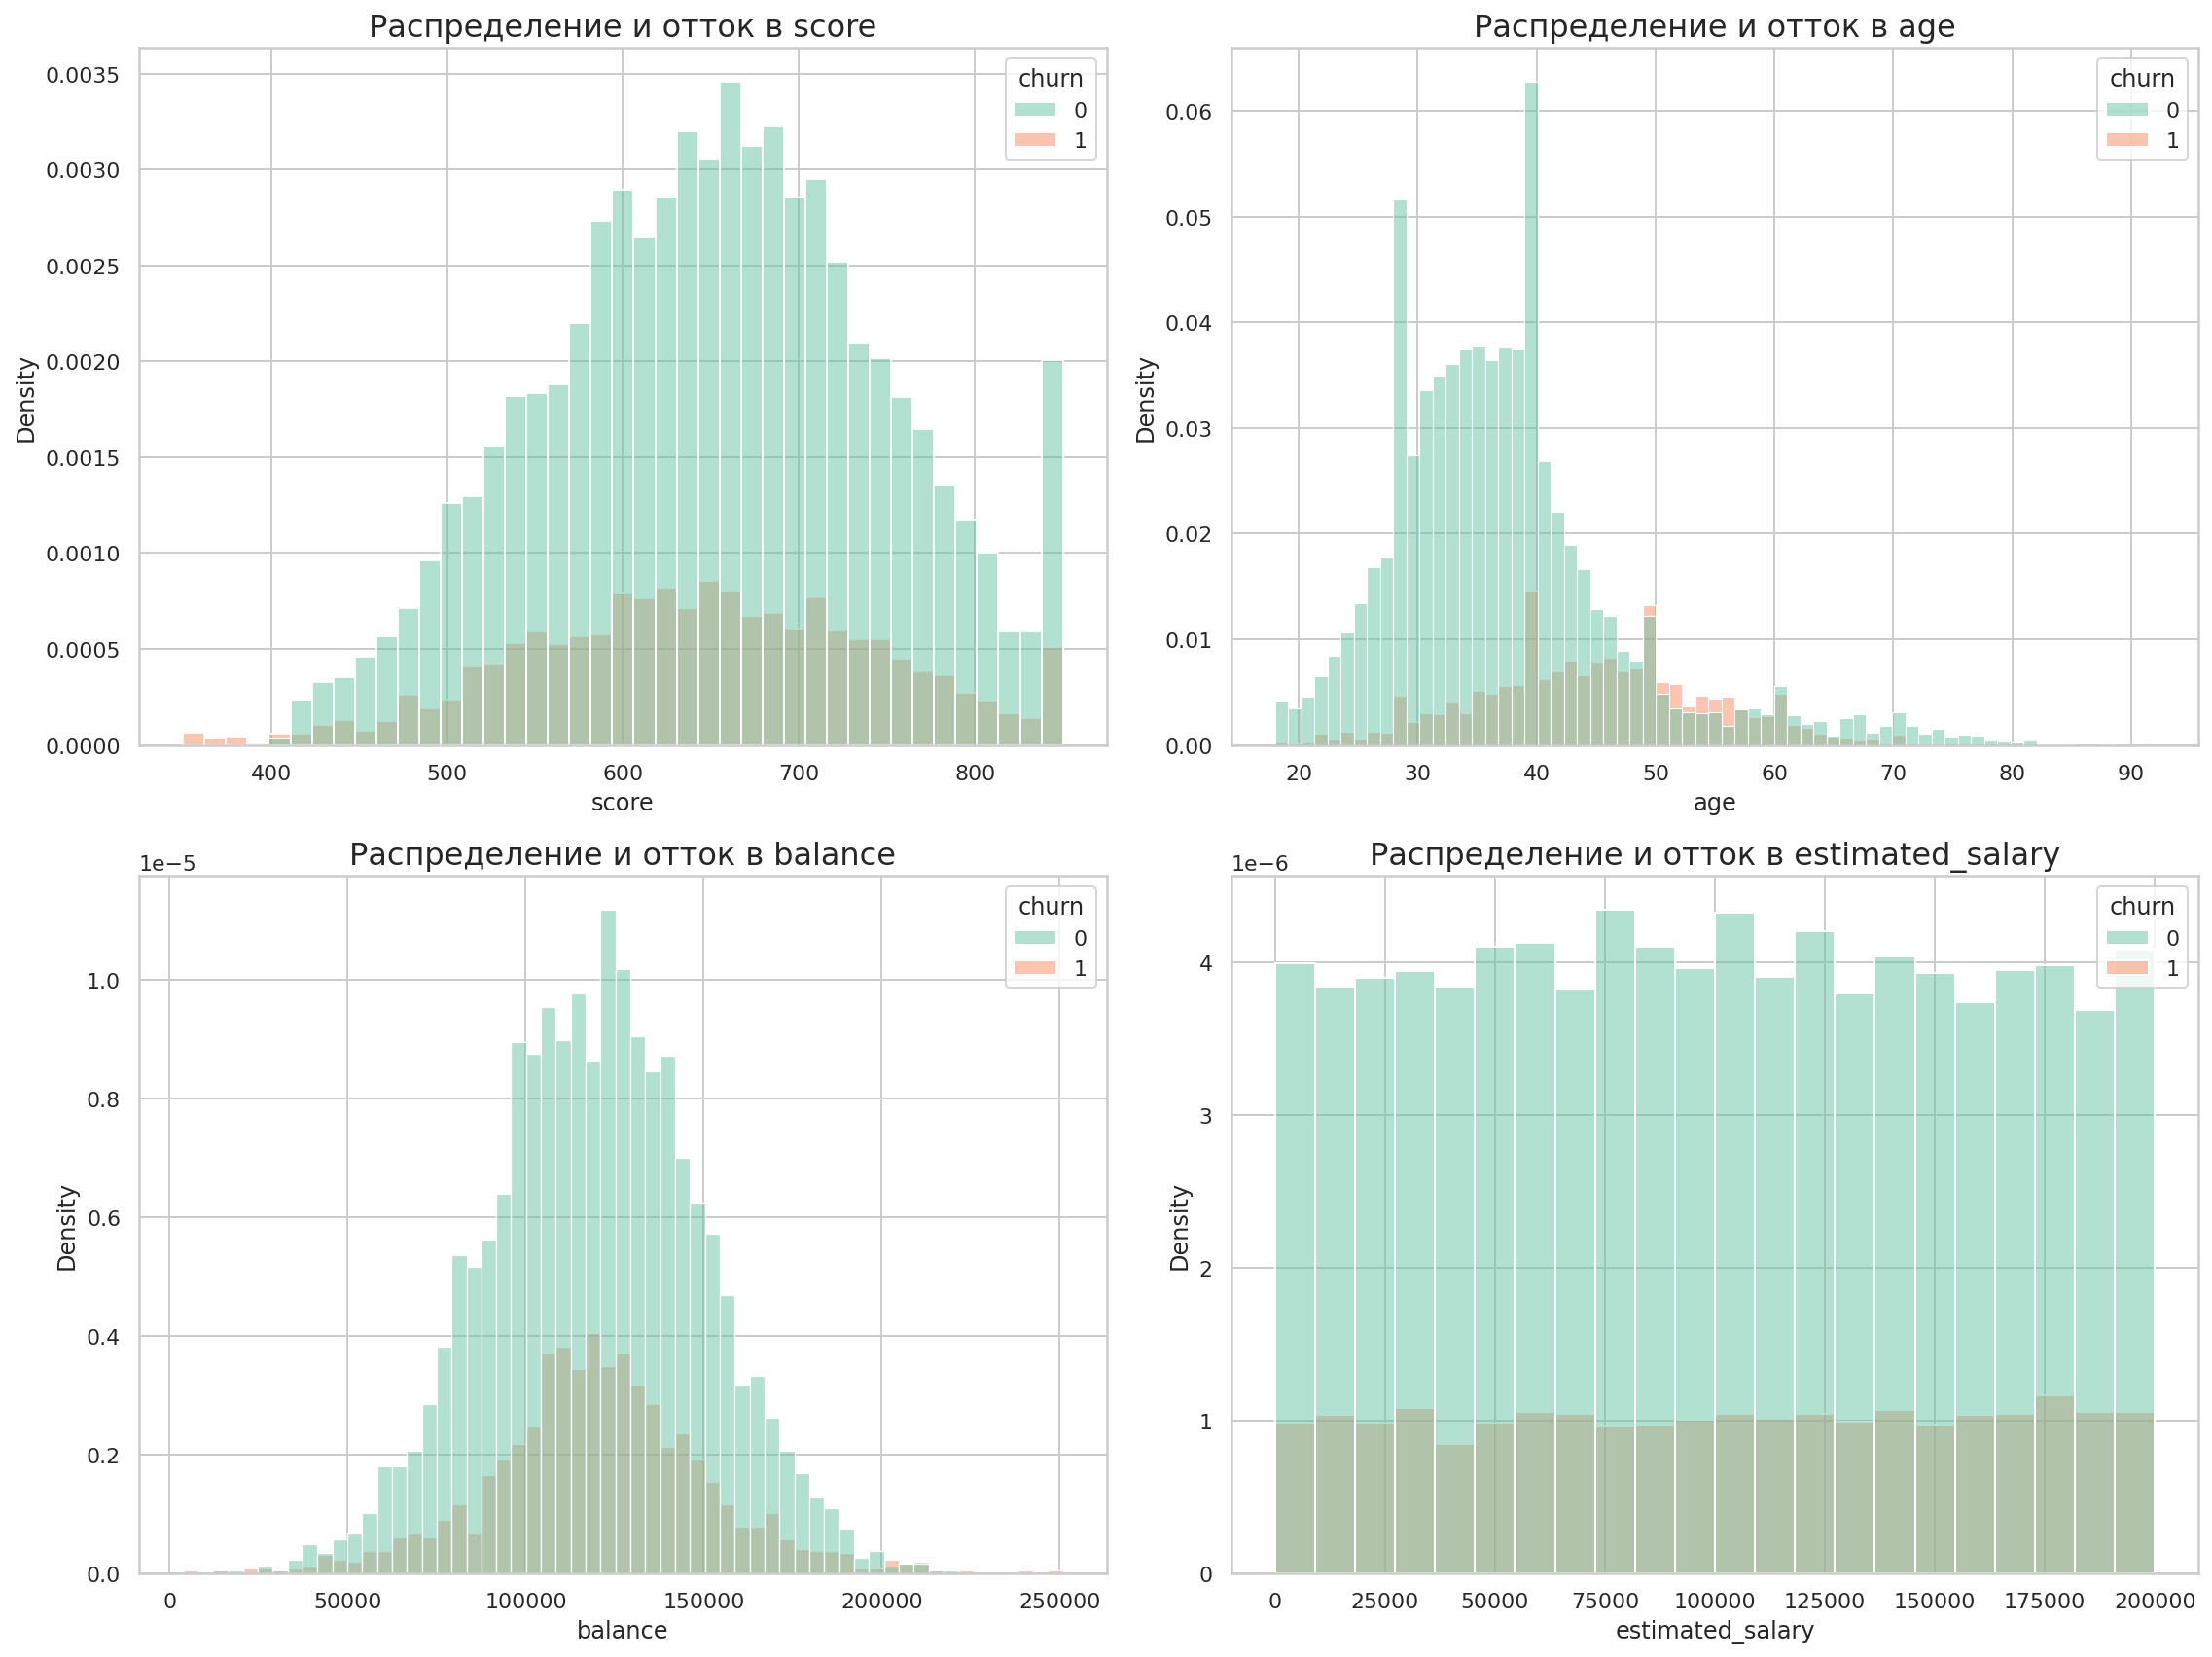

In [21]:
# вывод диаграмм распределения в цикле
fig = plt.figure(figsize=(16,12))
c = 1
for feature in df[cont_metrics[:-2]]:
    plt.subplot(2, 2, c)
    plt.xlabel(feature)
    plt.title('Распределение и отток в {}'.format(feature), fontsize=16)
    ax = sns.histplot(data=df, x=feature, hue='churn',
                      stat='density', palette='Set2')
    c = c + 1

plt.tight_layout()
plt.show();

Что полезного тут мы видим:

1. Нормальное распределение клиентов и оттока по кредитному рейтингу. Выбросы ниже 400 баллов и значительная группа на крайнем верхнем значении, которая выглядит неестественно;
2. По возрасту – распределение нормальное, но есть выбросs после 60, их можно будет почистить;
3. Нормальное распределение по признакам баланса и расчетной заработной платы.



Выведем распределение категориальных признаков в цикле с логарифмической шкалой:

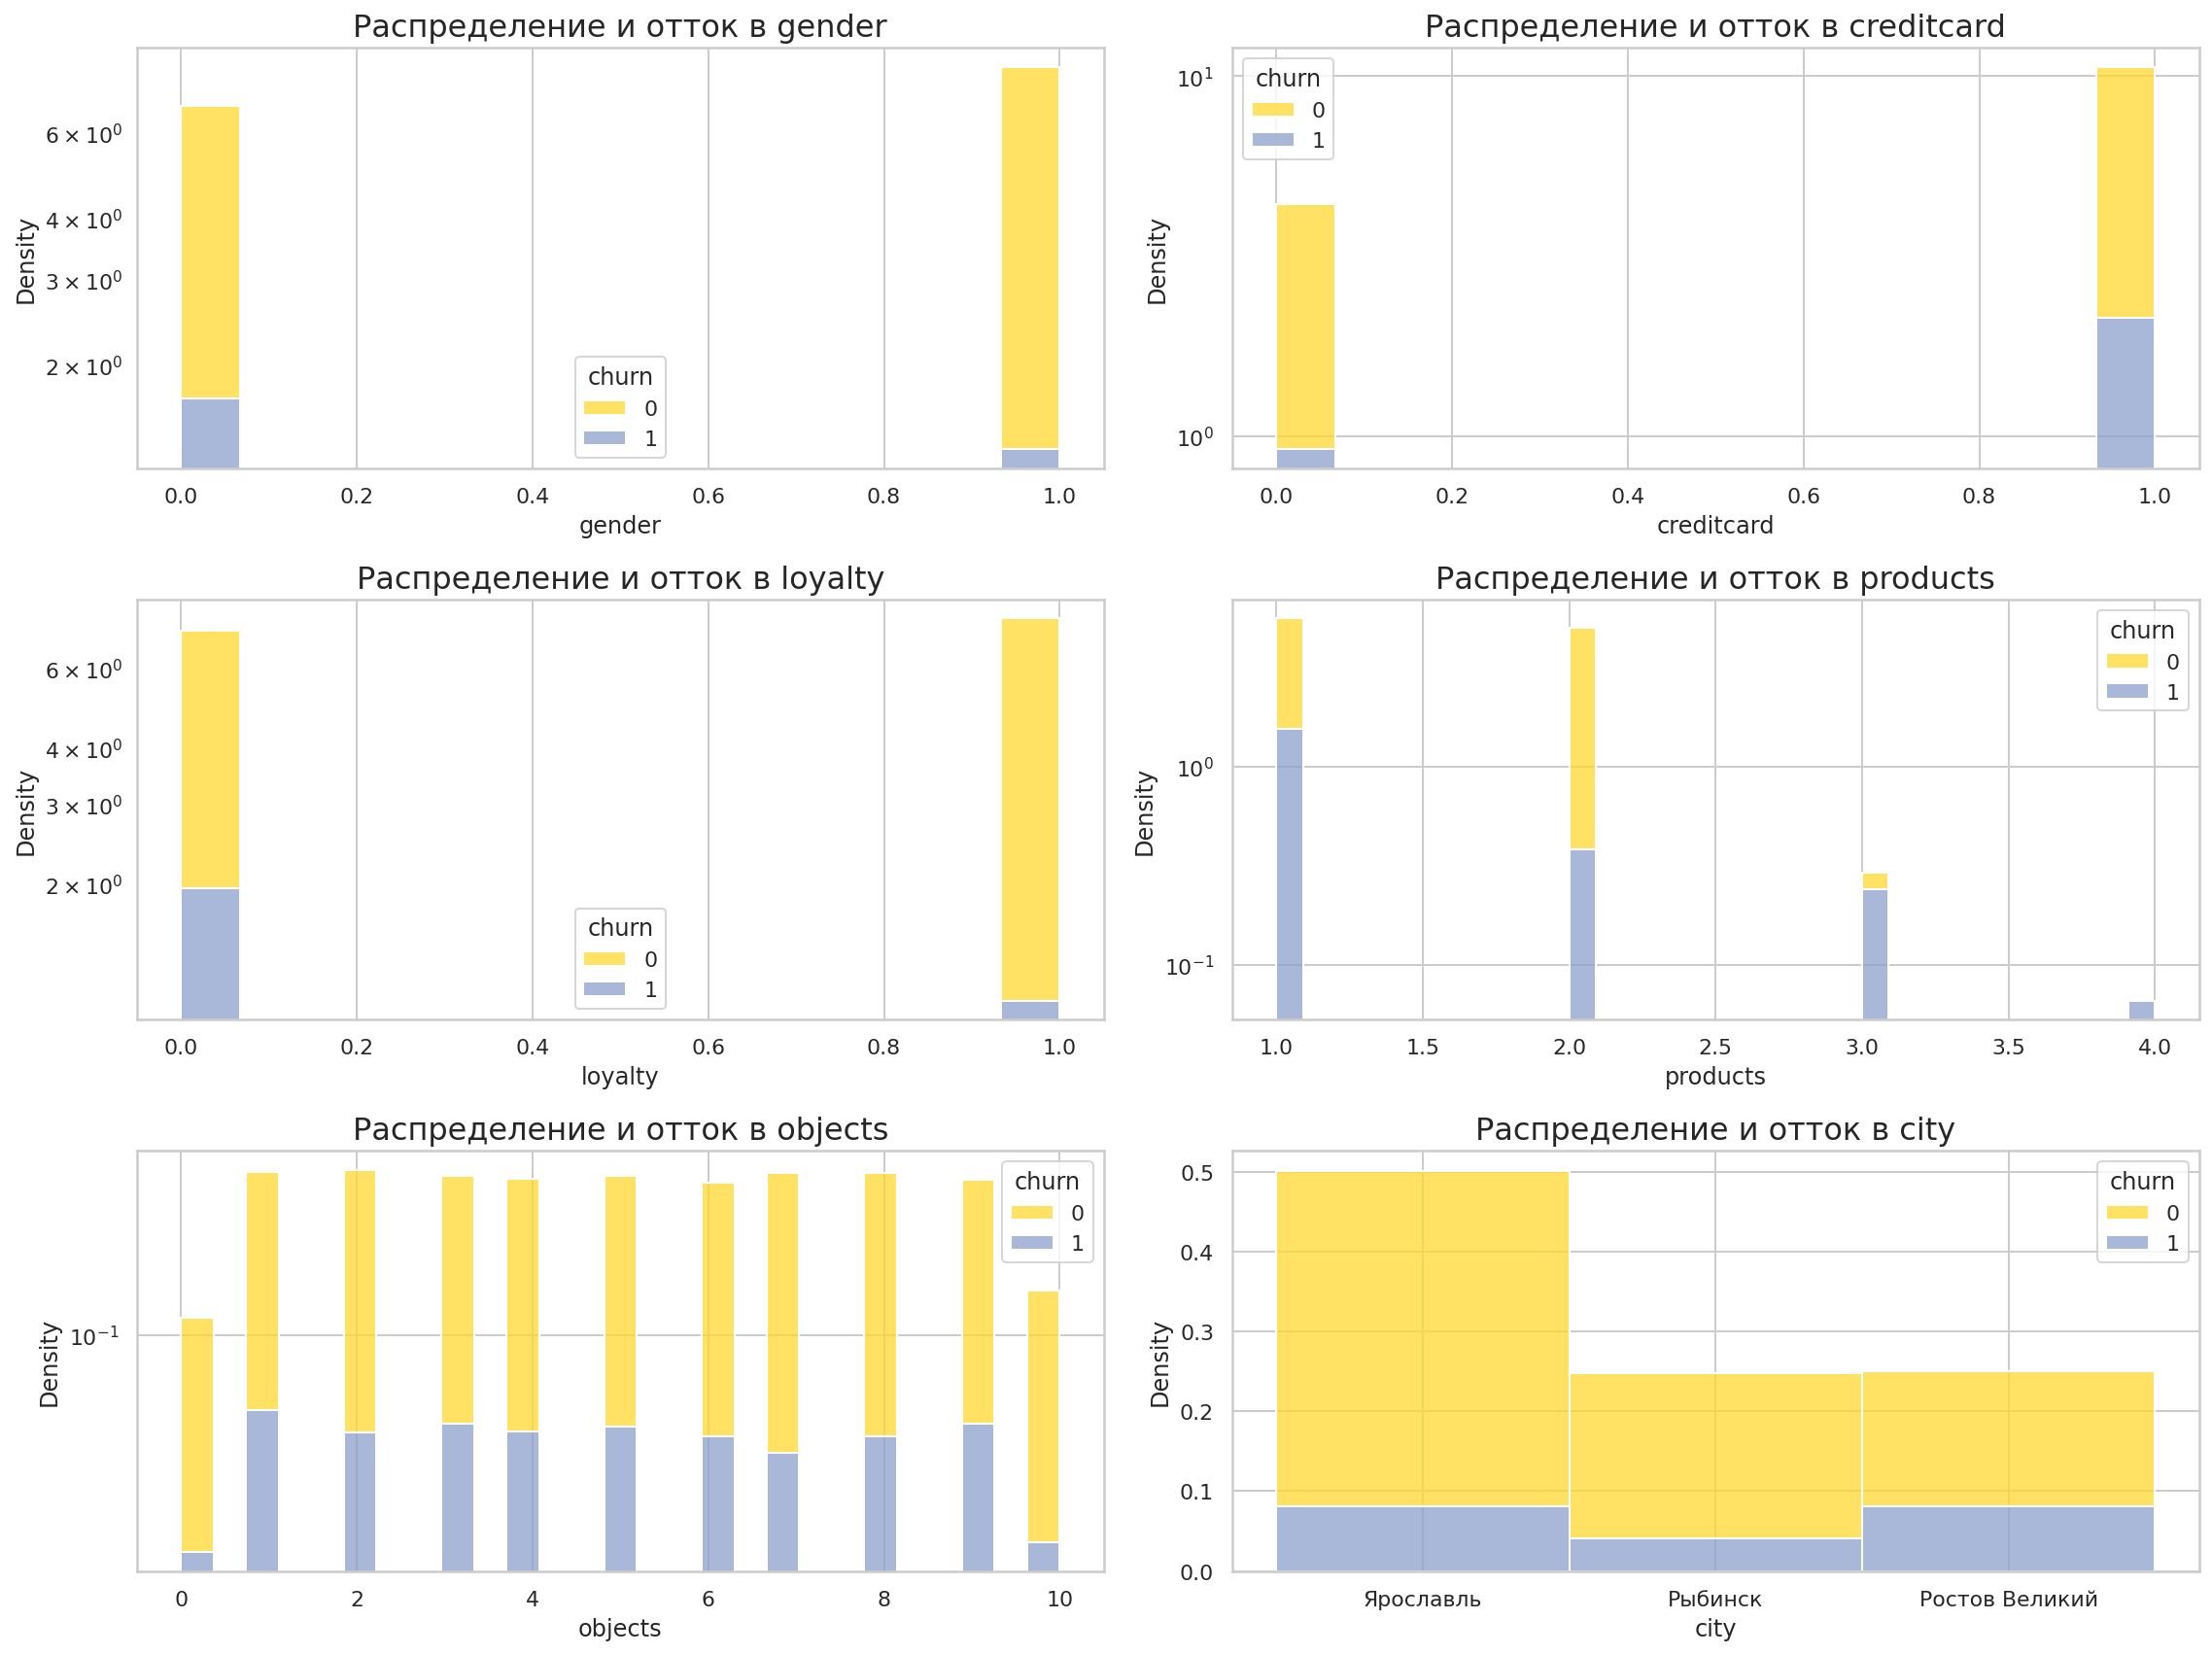

In [22]:
# вывод диаграмм распределения в цикле
fig = plt.figure(figsize=(16,12))
c = 1
for feature in df[cat_metrics[:-5]]:
    plt.subplot(3, 2, c)
    plt.xlabel(feature)
    plt.title('Распределение и отток в {}'.format(feature), fontsize=16)
    ax.set_yscale('log')
    ax = sns.histplot(data=df, x=feature, hue='churn', stat='density', 
                      multiple='stack', palette='Set2_r')
    c = c + 1

plt.tight_layout()
plt.show();

Что полезного тут мы видим:

1. Доля оттока женщин выше, чем доля мужчин;
2. Большинство ушедших – это клиенты с кредитными картами. Но учитывая, что у большинства клиентов есть кредитные карты, это может оказаться просто совпадением;
3. У неактивных клиентов отток заметно больше. Беспокоит то, неактивных клиентов в банке почти столько же, как активных.
4. У клиентов с количеством продуктов 3 очень высокая доля оттока. Клиенты с 4 продуктами все в оттоке, хоть их и мало;
5. По количеству объектов примерно одинаковые относительные доли оттока, выделяются только крайние показатели – 0 и 1- продуктов, у них доля оттока ниже средней;
6. Больше всего клиентов из Ярославля. Тем не менее, доля ушедших клиентов в Ростове Великом практически такая же, несмотря на самое меньшее число клиентов. Это может указывать на то, что у банка в Ростове Великом, возможно, есть проблемы, которые нужно выявить и решить (например, плохое обслуживание, неудобное расположение офисов, невыгодные для клиентов тарифы и т.п.).


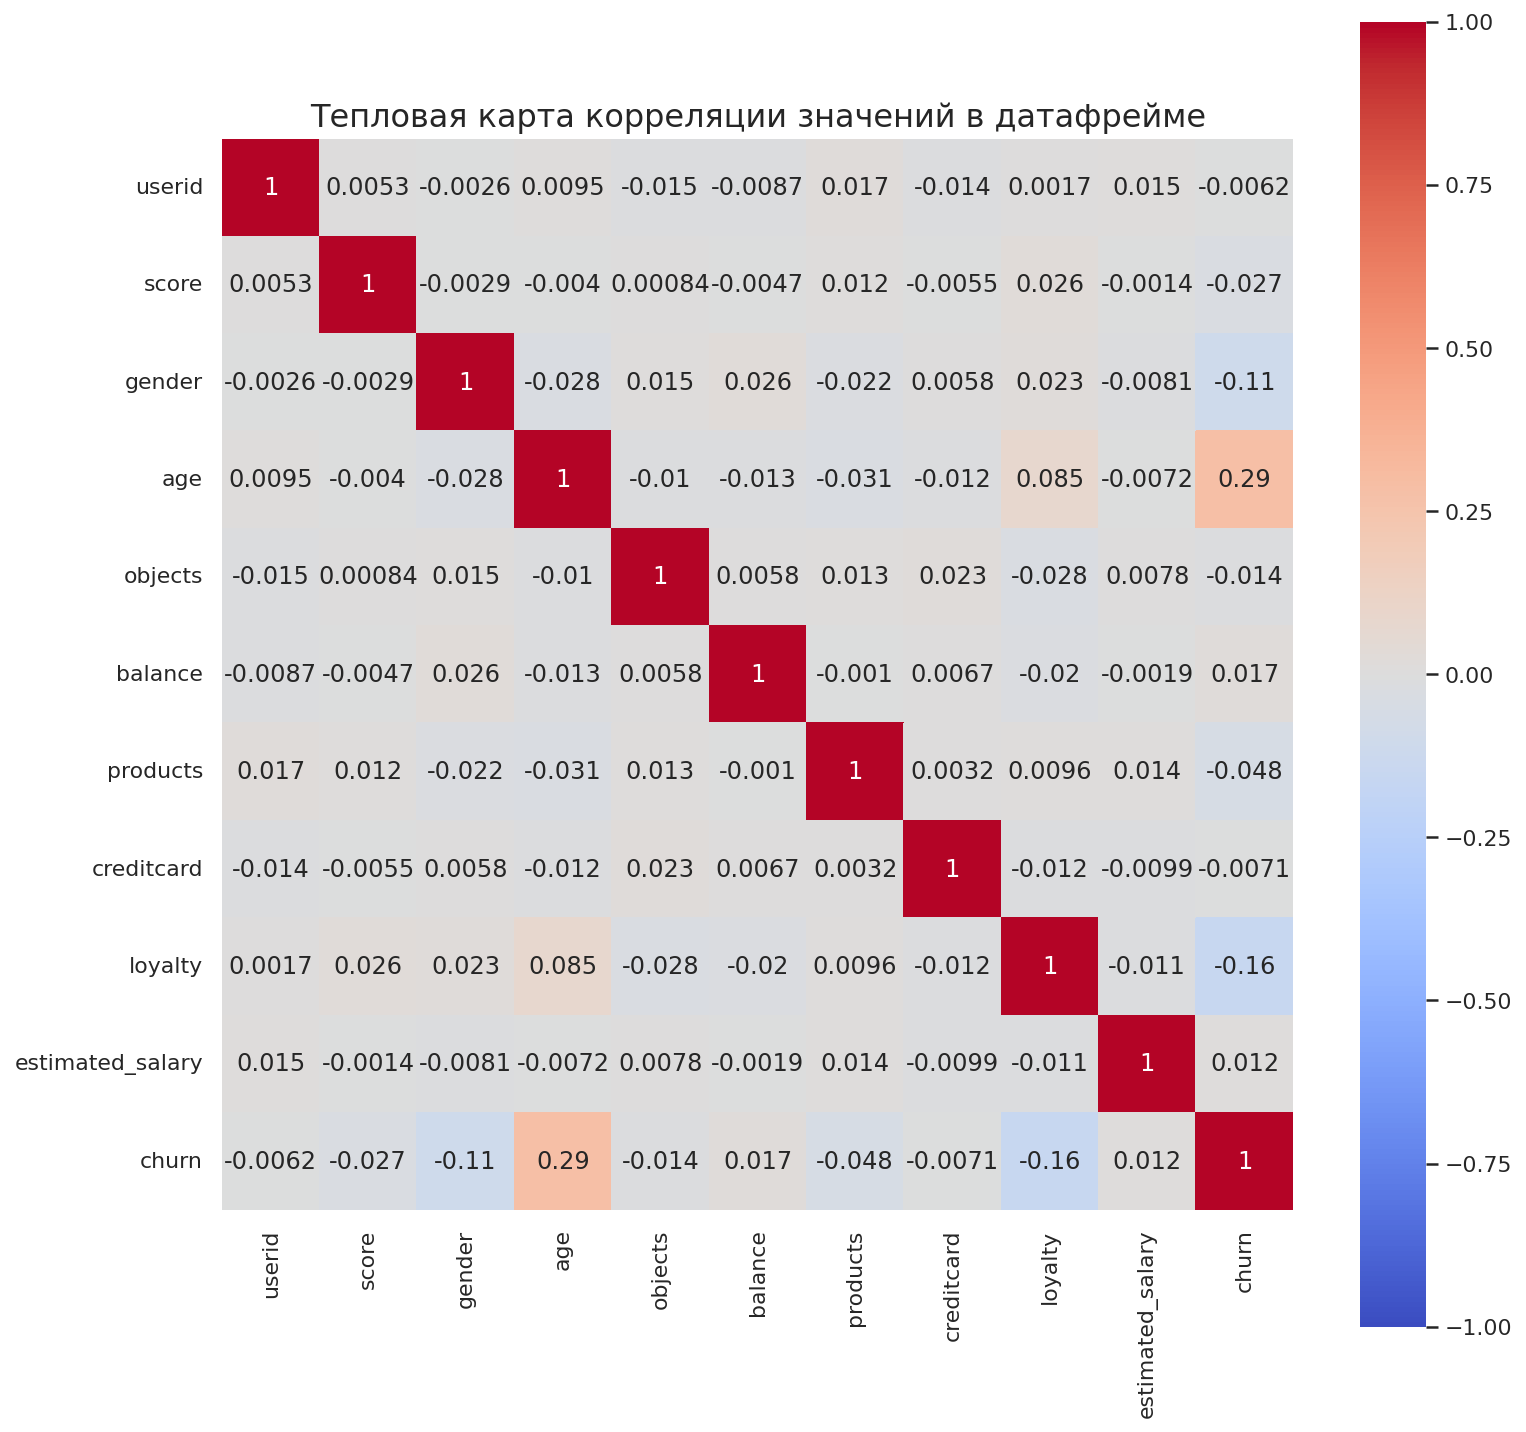

In [23]:
# построение тепловой матрицы корреляций
cm = df.corr()

plt.figure(figsize=(12,12))
plt.title('Тепловая карта корреляции значений в датафрейме', fontsize=16)

sns.heatmap(cm, square=True, annot=True, cmap='coolwarm', vmin=-1, vmax=1);

В оригинальном датасете обнаружена умеренная корреляция оттока с признаком **возраст** (по шкале Чеддока). 

Попробуем очистить датасет от выбросов, чтобы получить более релевантные данные.

### Очистка от выбросов

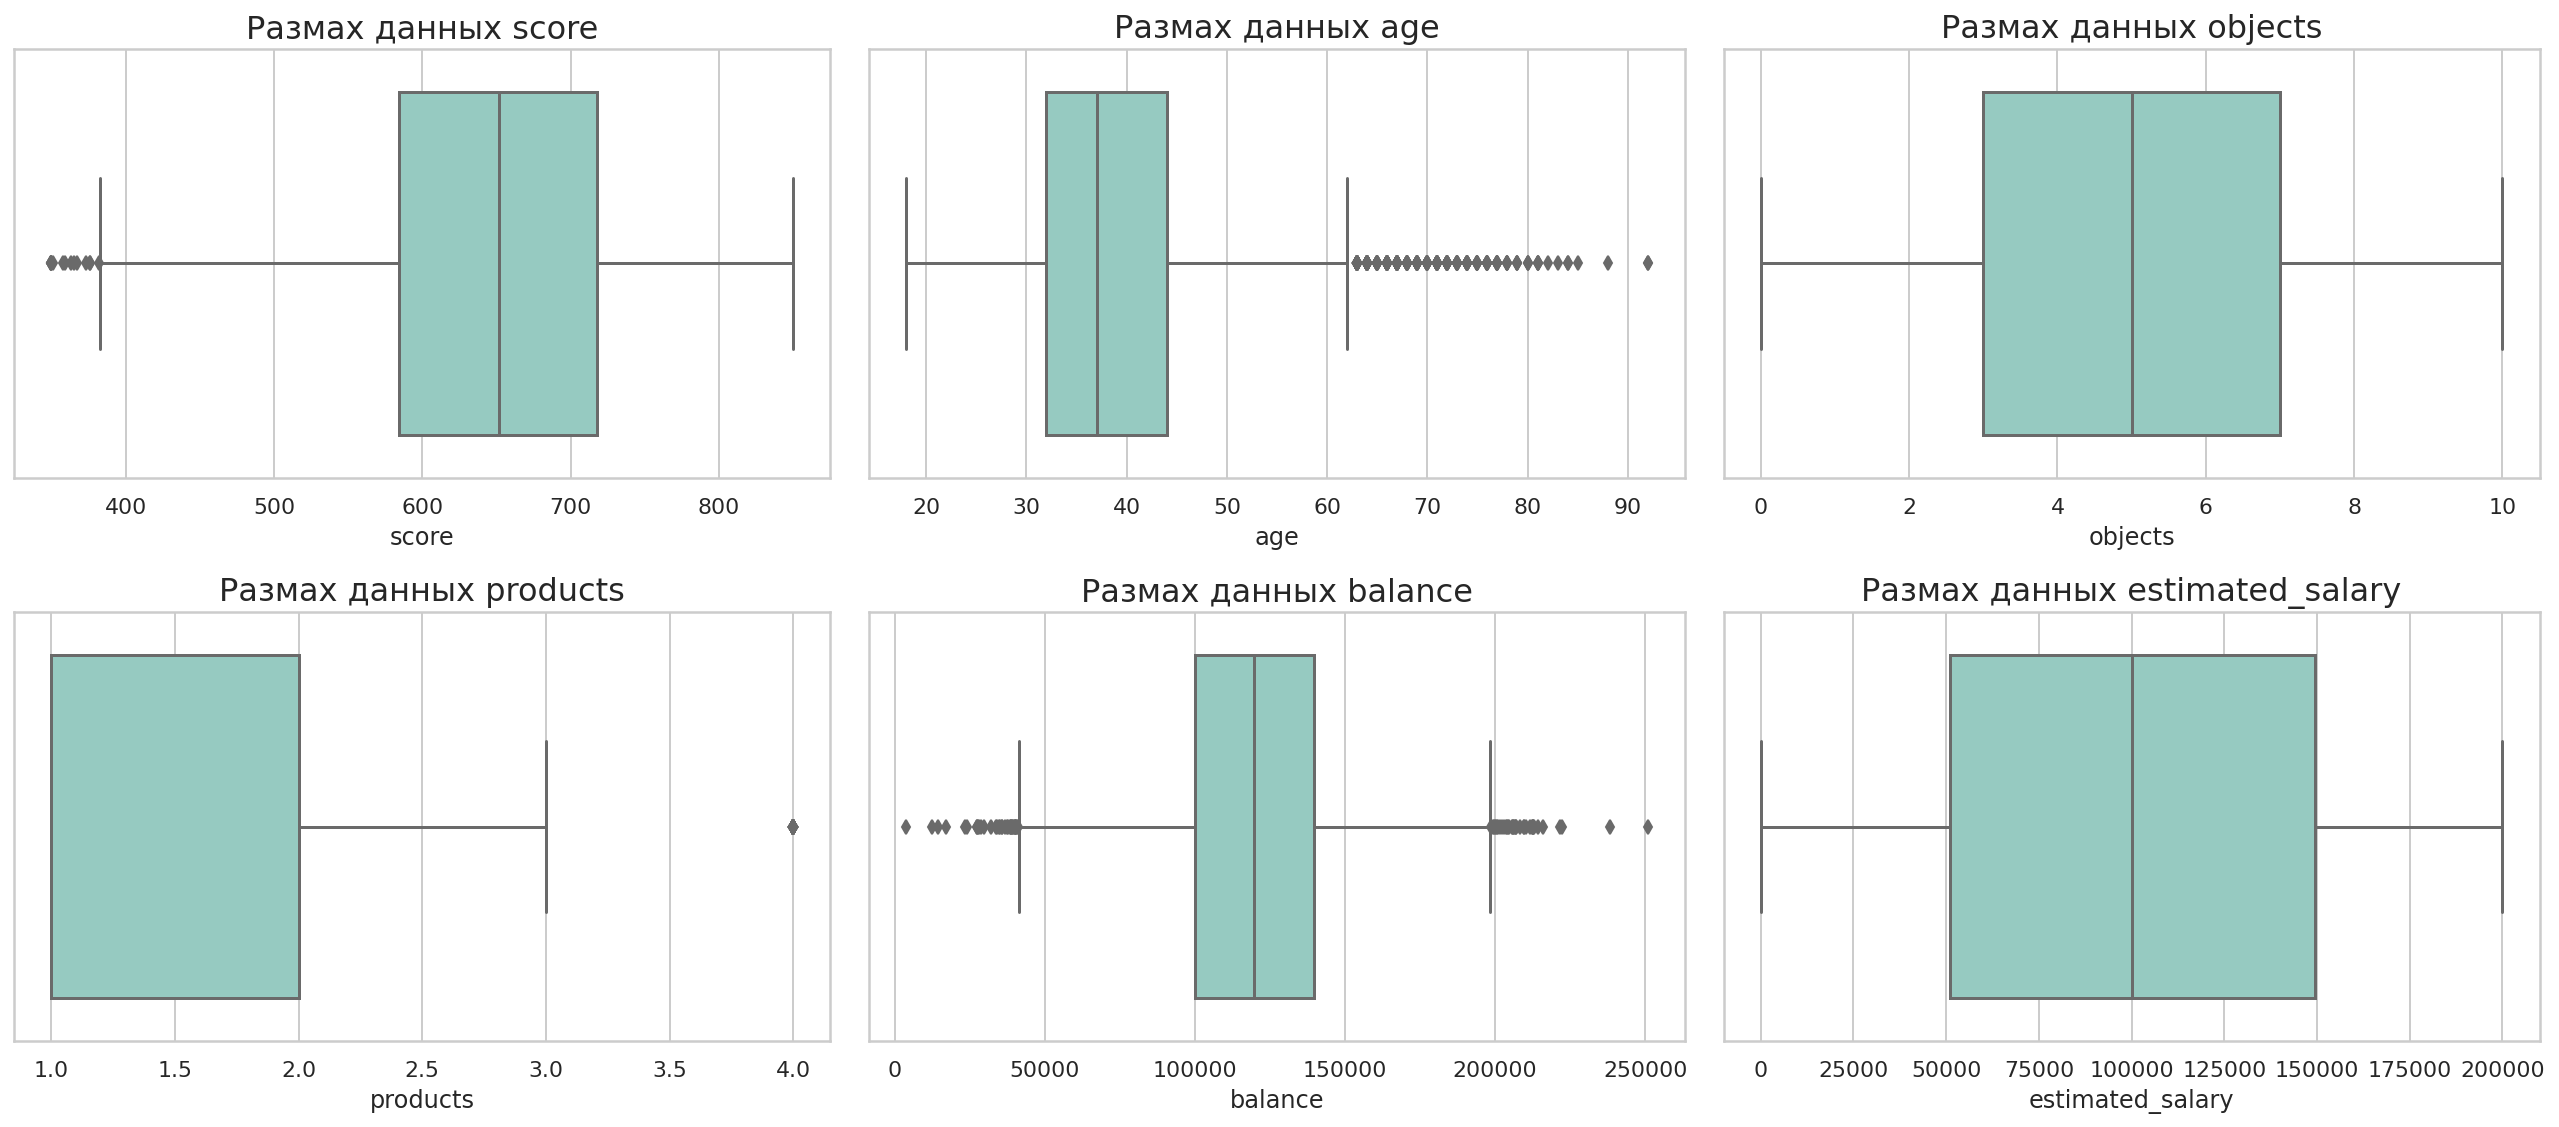

In [24]:
# создание списка кличественных признаков
feature_list = ['score', 'age', 'objects',\
                'products', 'balance', 'estimated_salary']

# вывод диаграмм в цикле
fig = plt.figure(figsize=(18,8))
c = 1
for feature in df_grouped[feature_list]:
    plt.subplot(2, 3, c)
    plt.xlabel(feature)
    plt.title('Размах данных {}'.format(feature), fontsize=16)
    ax = sns.boxplot(data=df_grouped, x=feature, palette='Set3');
    c = c + 1

plt.tight_layout()
plt.show();

Что удалось узнать:
- Кредитный рейтинг ниже 400: ненадежные клиенты, зато в банке их немного
- Возраст выше 62: пенсионеры, не являются ключевыми клиентами, судя по выбросам
- 4 используемых банковских продукта – редкость, в основном 1-2 продукта
- Баланс счета до 50000 или выше 200000 – тоже не основная часть клиентов
- Средняя заработная плана рассчитана алгоритмом, поэтому распределение довольно равномерное

Создадим отдельный датасет без аномальных значений, убрав выбросы с помощью IQR:

In [25]:
# расчет границ выбросов по квантилям
Q1 = df_grouped[feature_list].quantile(0.25)
Q3 = df_grouped[feature_list].quantile(0.75)
IQR = Q3 - Q1

# создание отфильтрованного датафрейма
df_fil = df_grouped[~((df_grouped[feature_list] < (Q1 - 1.5 * IQR)) \
                   |(df_grouped[feature_list] > (Q3 + 1.5 * IQR))).any(axis=1)]

df_fil.shape

(9498, 16)

Осталось 9498 строк, что составляет ~95% от начальной базы. Много данных мы не потеряли.

Теперь можно рассмотреть очищенные данные подробнее.

### Тепловая матрица корреляций

Построим тепловую матрицу для очищенного от выбросов датасета.

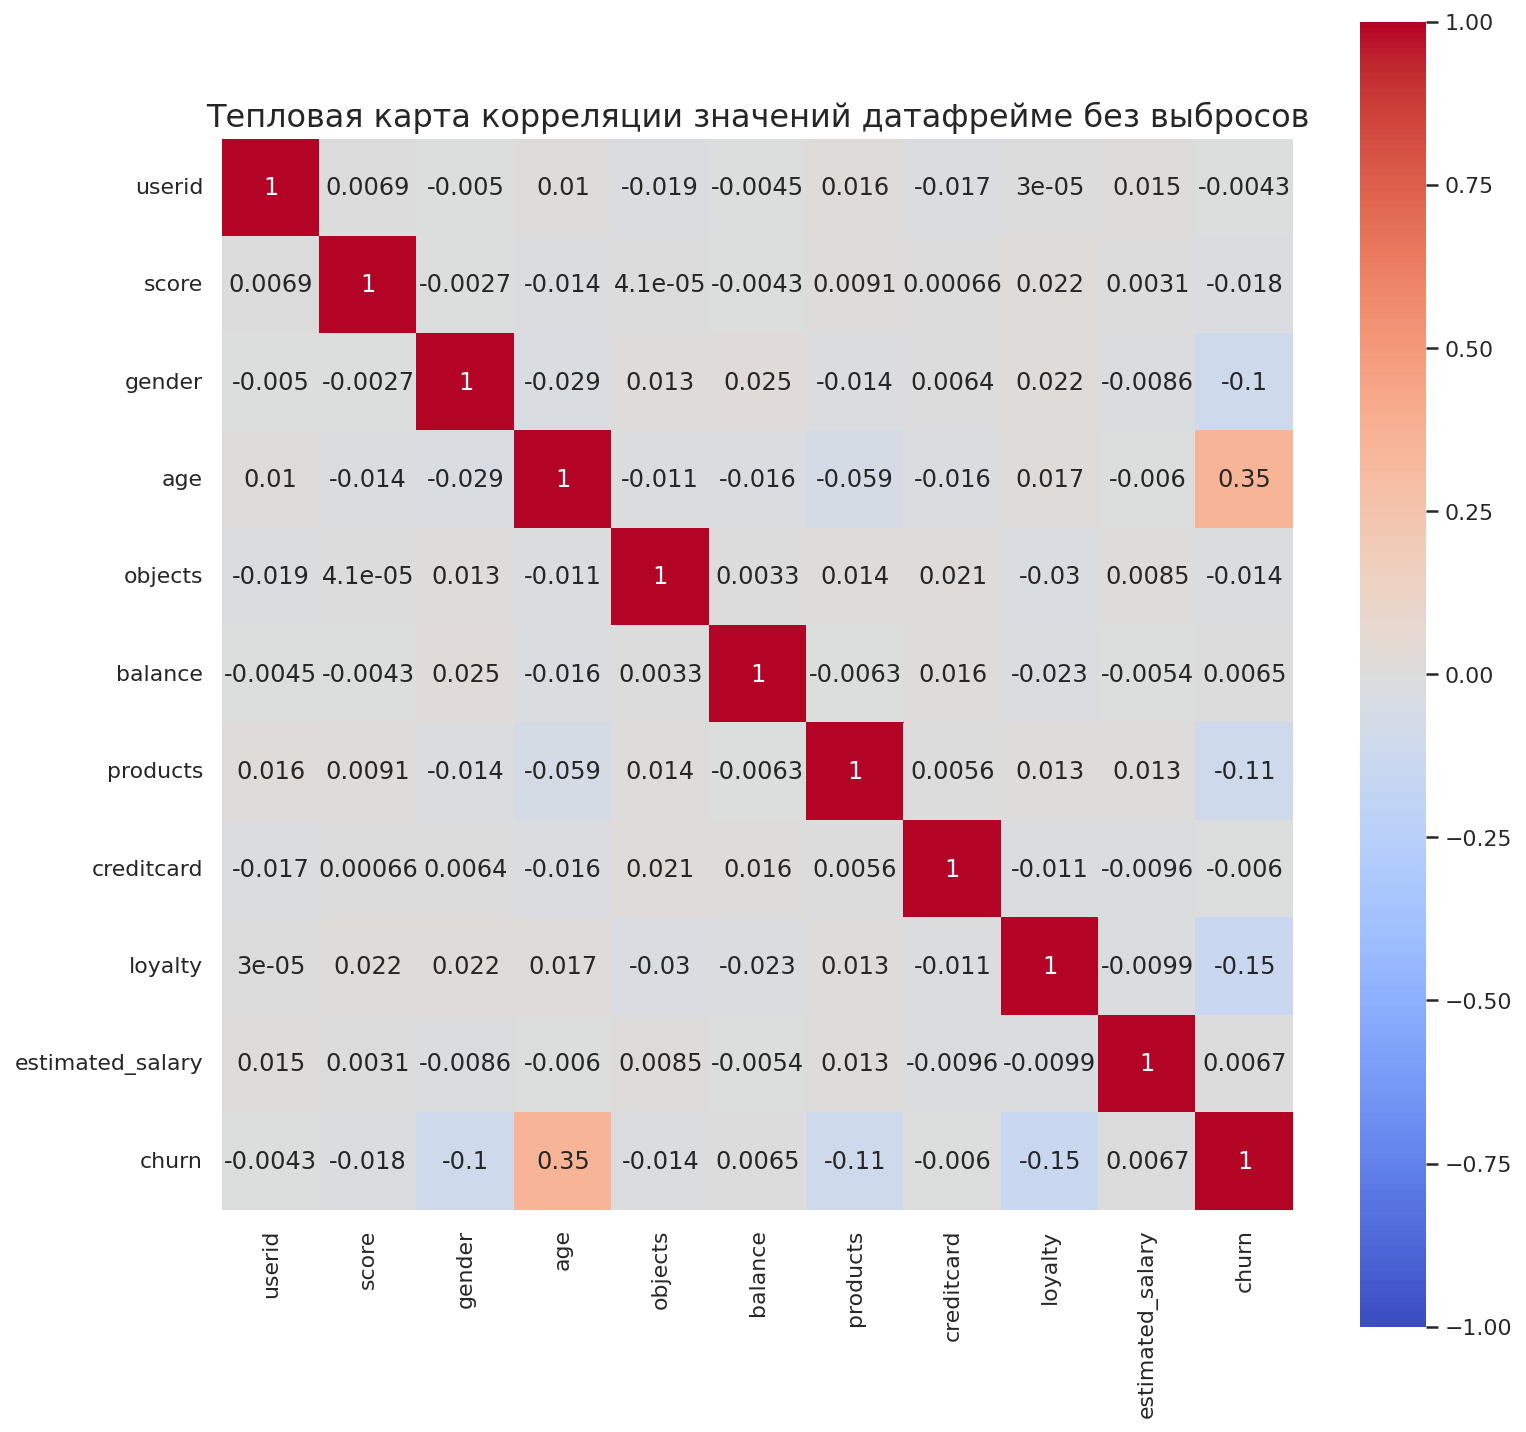

In [26]:
# построение тепловой матрицы корреляций
cm = df_fil.corr()

plt.figure(figsize=(12,12))
plt.title('Тепловая карта корреляции значений датафрейме без выбросов', fontsize=16)

sns.heatmap(cm, square=True, annot=True, cmap='coolwarm', vmin=-1, vmax=1);

Умеренная корреляция оттока с признаком **возраст** после очистки от выбросов стала немного сильнее. 


Рассмотрим подробнее группы с оттоком и без оттока, и составим портреты клиентов, склонных к уходу из банка.

### Сегментация пользователей

#### Средний клиент

Выведем статистики, чтобы отталкиваться от средних по отфильтрованному датасету:

In [27]:
# вывод статистик датасета
df_fil.drop(columns='userid').describe().T

,count,mean,std,min,25%,50%,75%,max
score,9498.00,650.71,96.14,383.00,584.00,652.00,718.00,850.00
gender,9498.00,0.55,0.50,0.00,0.00,1.00,1.00,1.00
age,9498.00,37.74,8.79,18.00,32.00,37.00,43.00,62.00
objects,9498.00,5.02,2.89,0.00,3.00,5.00,7.00,10.00
balance,6033.00,119757.76,28735.89,41299.03,100359.54,119769.77,139196.00,198338.77
products,9498.00,1.52,0.55,1.00,1.00,1.00,2.00,3.00
creditcard,9498.00,0.71,0.46,0.00,0.00,1.00,1.00,1.00
loyalty,9498.00,0.50,0.50,0.00,0.00,1.00,1.00,1.00
estimated_salary,9498.00,99996.07,57524.56,11.58,50907.11,99954.45,149383.65,199992.48
churn,9498.00,0.20,0.40,0.00,0.00,0.00,0.00,1.00


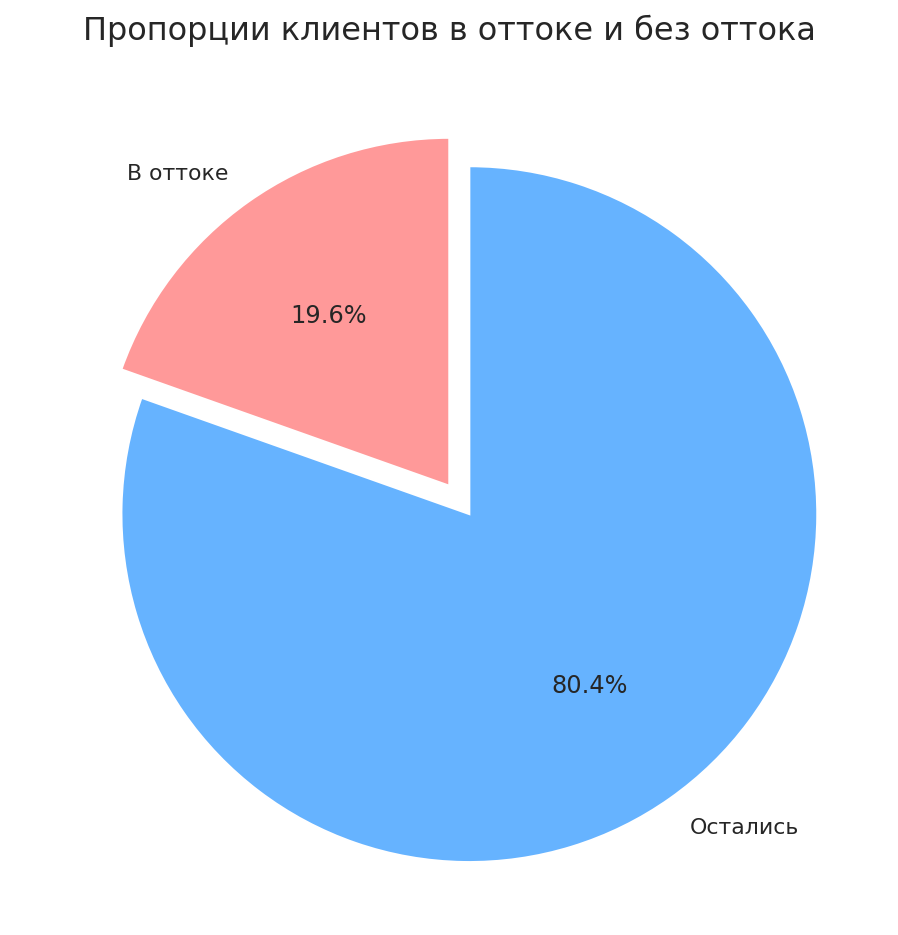

In [28]:
# вывод диаграммы с долей оттока
labels = 'В оттоке', 'Остались'
sizes = [df_fil.churn[df_fil['churn']==1].count(), df_fil.churn[df['churn']==0].count()]
explode = (0, 0.1)
fig1, ax = plt.subplots(figsize=(10, 8))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', \
       startangle=90, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title('Пропорции клиентов в оттоке и без оттока', size=16)
plt.show()

Медианный клиент в датасете без выбросов:

- кредитный рейтинг 652 ("хороший")
- мужчина (55% клиентов)
- 37 лет
- 5 объектов в собственности
- 97000 уе на балансе
- 1 банковский продукт (1.52 в среднем)
- 71% имеет кредитную карту
- активен (50%)
- заработная плата 100000 уе
- 20% оттока


#### Сегмент 0: клиенты без оттока

In [29]:
# выборка клиентов без оттока по всем городам
no_churn_total = df_fil.query('churn == 0')

# статистики по выборке
no_churn_total.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,7639.00,15733835.03,71644.96,15608437.00,15671500.00,15734607.00,15795690.50,15858426.00
score,7639.00,651.57,95.72,405.00,584.50,653.00,718.00,850.00
gender,7639.00,0.57,0.49,0.00,0.00,1.00,1.00,1.00
age,7639.00,36.20,8.02,18.00,31.00,36.00,41.00,62.00
objects,7639.00,5.04,2.88,0.00,3.00,5.00,7.00,10.00
balance,4641.00,119656.18,29024.22,41299.03,99557.94,119825.75,139707.28,198338.77
products,7639.00,1.55,0.51,1.00,1.00,2.00,2.00,3.00
creditcard,7639.00,0.71,0.46,0.00,0.00,1.00,1.00,1.00
loyalty,7639.00,0.54,0.50,0.00,0.00,1.00,1.00,1.00
estimated_salary,7639.00,99807.29,57406.15,90.07,50811.47,99692.65,148689.39,199992.48


 В выборке большая асть базы – 7639 клиентов. 
 
 Портрет клиента без оттока ("идеальный клиент") по всей выборке в целом:

- **Мужчина**
- Возраст от 31 до 41 года, медиана **возраста 36**
- 5 объектов в собственности
- Кредитный рейтинг хороший, в среднем 653
- **Использует 2 банковских продукта**
- Имеет кредитную карту
- **Активен**
- Баланс около 120000 уе 
- Расчетная средняя заработная плата около 100000 уе

#### Сегмент 1: клиенты с оттоком

In [30]:
# выборка клиентов с оттоком по всем городам
churn_total = df_fil.query('churn == 1')

# статистики по выборке
churn_total.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,1859.00,15733049.55,72729.53,15608442.00,15670597.50,15732517.00,15795869.00,15858392.00
score,1859.00,647.18,97.80,383.00,579.00,647.00,718.00,850.00
gender,1859.00,0.44,0.50,0.00,0.00,0.00,1.00,1.00
age,1859.00,44.04,8.98,18.00,38.00,44.00,51.00,62.00
objects,1859.00,4.94,2.94,0.00,2.00,5.00,8.00,10.00
balance,1392.00,120096.43,27760.43,41473.33,103668.49,119597.15,137458.00,194532.66
products,1859.00,1.40,0.68,1.00,1.00,1.00,2.00,3.00
creditcard,1859.00,0.70,0.46,0.00,0.00,1.00,1.00,1.00
loyalty,1859.00,0.36,0.48,0.00,0.00,0.00,1.00,1.00
estimated_salary,1859.00,100771.83,58017.69,11.58,51406.65,100722.72,151878.29,199808.10


In [31]:
churn_total['gender'].value_counts()

0    1035
1     824
Name: gender, dtype: int64

In [32]:
# расчет доли оттока по возрасту
churn_total_ratio = df_fil.groupby(['gender', 'age'])\
                  .agg({'churn':'sum', 'age':'count'})\
                  .rename(columns={'age': 'total'})\
                  .sort_values(by='total', ascending=False).reset_index()
churn_total_ratio['ratio'] = churn_total_ratio['churn'] \
                          / churn_total_ratio['total'] * 100

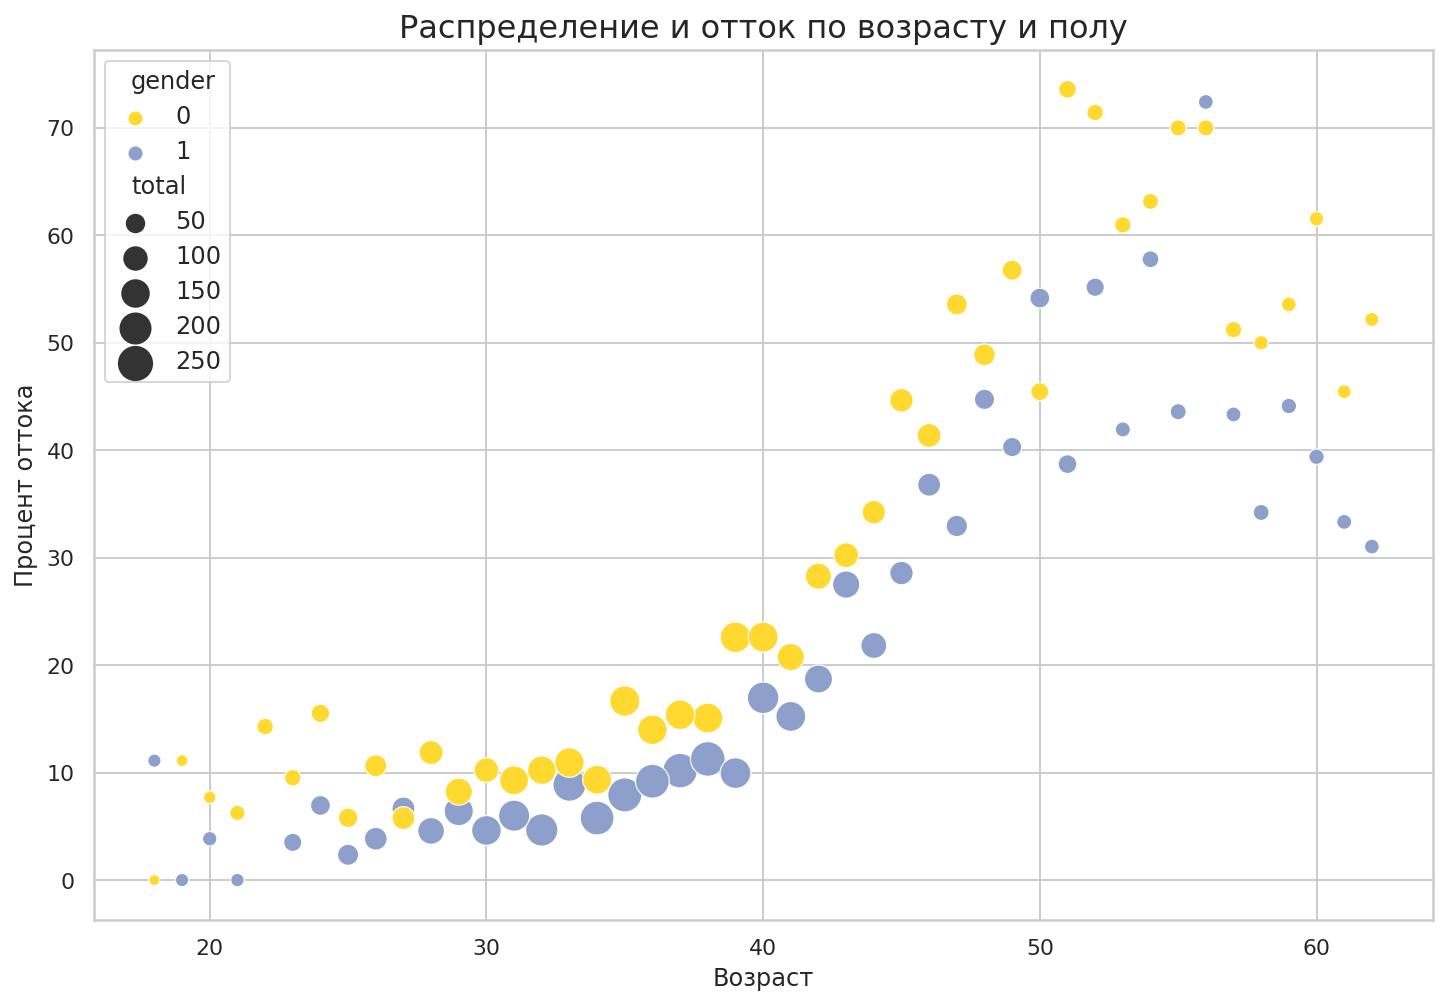

In [33]:
# вывод диаграммы распределения
fig = plt.figure(figsize=(12,8))

plt.xlabel('Возраст')
plt.ylabel('Процент оттока')
plt.title('Распределение и отток по возрасту и полу', fontsize=16)
ax = sns.scatterplot(data=churn_total_ratio, x='age', y='ratio',\
                     hue='gender', palette='Set2_r', size='total',\
                     sizes=(30, 300))
plt.show();

 В выборке 1891 клиент. Женщин больше, чем мужчин, на 25%.
 
 Самый большой процент оттока (выше 40%) наблюдается в возрастном диапазоне 45-60 лет.

 Портрет клиента с оттоком по всей выборке в целом:

- **Чаще женщина**
- Возраст от 38 до 51 года, в среднем **в возрасте 44+**
- 5 объектов собственности
- Кредитный рейтинг хороший, в среднем 647
- **Использует 1 банковский продукт**
- Имеет кредитную карту
- **Не активен**
- Баланс около 120000 уе 
- Расчетная средняя заработная плата около 100000 уе

Уже видим **показатели, которые скорее всего влияют на отток**:

- пол
- возраст
- активность
- количество банковских продуктов

### Портреты пользователей


#### По полу


In [34]:
# расчет доли оттока по возрастным группам
gender_churn_ratio = df_fil.groupby(['gender' ,'age']) \
                           .agg({'churn':'sum', 'userid':'count'})\
                           .rename(columns={'userid': 'total'})\
                           .sort_values(by='total', ascending=False)\
                           .reset_index()
gender_churn_ratio['ratio'] = gender_churn_ratio['churn']\
                            / gender_churn_ratio['total'] * 100
gender_churn_ratio.groupby('gender')\
                  .agg({'total':'sum', 'churn':'sum','ratio':'median'})

,total,churn,ratio
gender,,,
0,4296,1035,22.60
1,5202,824,15.23


В статистиках видим, что количество клиентов в оттоке женского пола больше, а показатель оттока более на 50% выше, чем у мужчин.

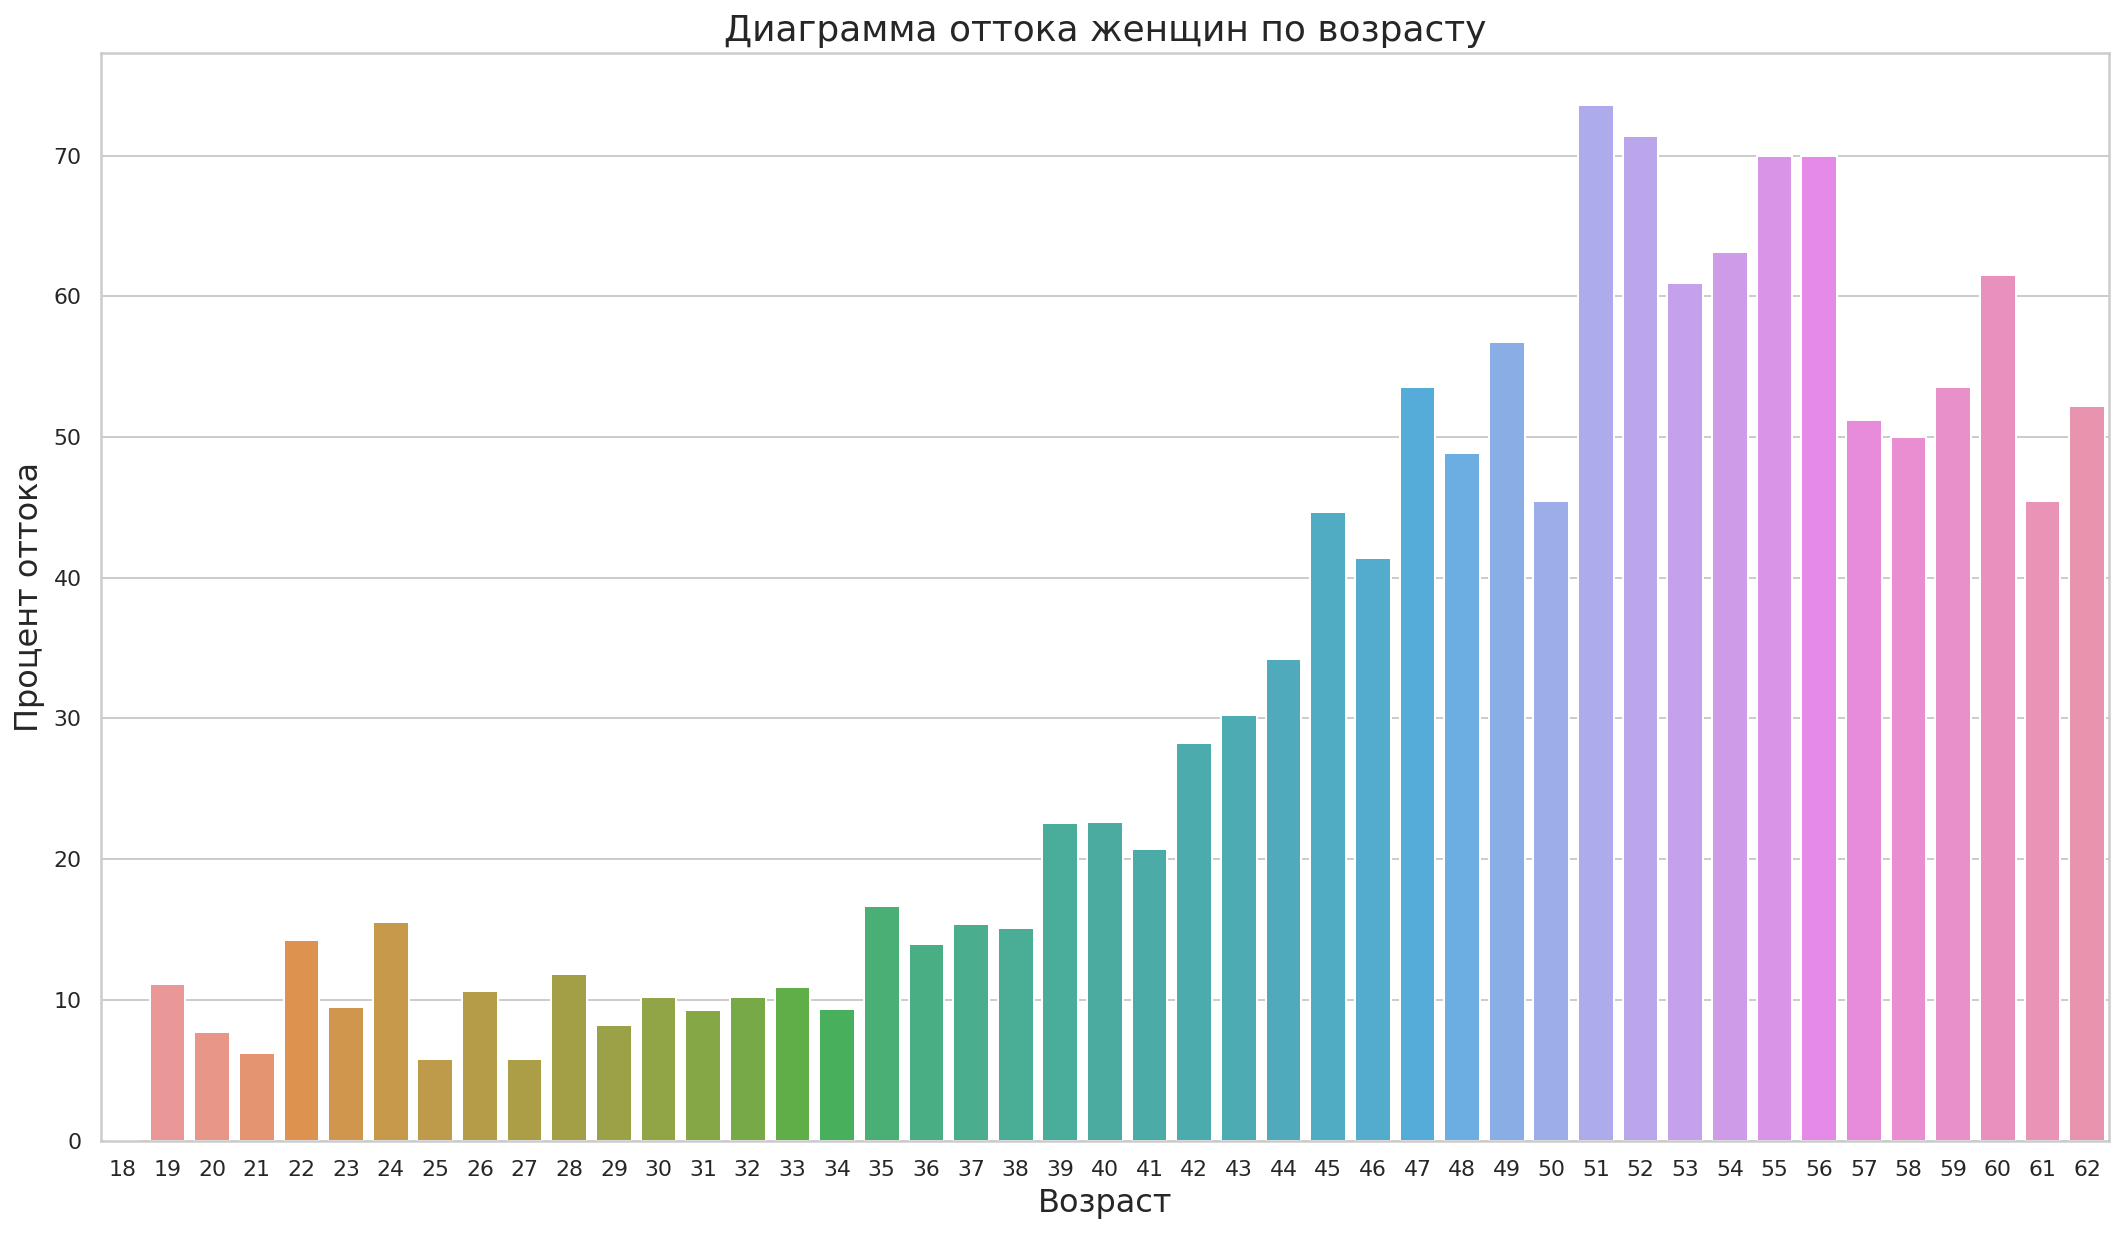

In [35]:
# построим график для визуализации выборки

plt.figure(figsize=(18,10))

sns.barplot(x=gender_churn_ratio.query('gender == 0')['age'],\
            y=gender_churn_ratio['ratio'], ci=None);
plt.title('Диаграмма оттока женщин по возрасту', fontsize=18);
plt.xlabel('Возраст', fontsize=16);
plt.ylabel('Процент оттока', fontsize=16);

Отток более 40% у женщин в возрастном диапазоне 45+.
 

Портрет №1: **Женщины 45+**

Инсайт: особый пик оттока (более 50%) приходится на диапазон женщин возраста 51-56. Менеджерам следует изучить этот сегмент, чтобы выделить опасения и пожелания группы.

#### По возрасту


In [36]:
# расчет доли оттока по возрасту
age_churn_ratio = df_fil.groupby(['gender' ,'age_group' , 'age']) \
                           .agg({'churn':'sum', 'userid':'count'})\
                           .rename(columns={'userid': 'total'})\
                           .sort_values(by='total', ascending=False)\
                           .reset_index()
age_churn_ratio['ratio'] = age_churn_ratio['churn']\
                            / age_churn_ratio['total'] * 100

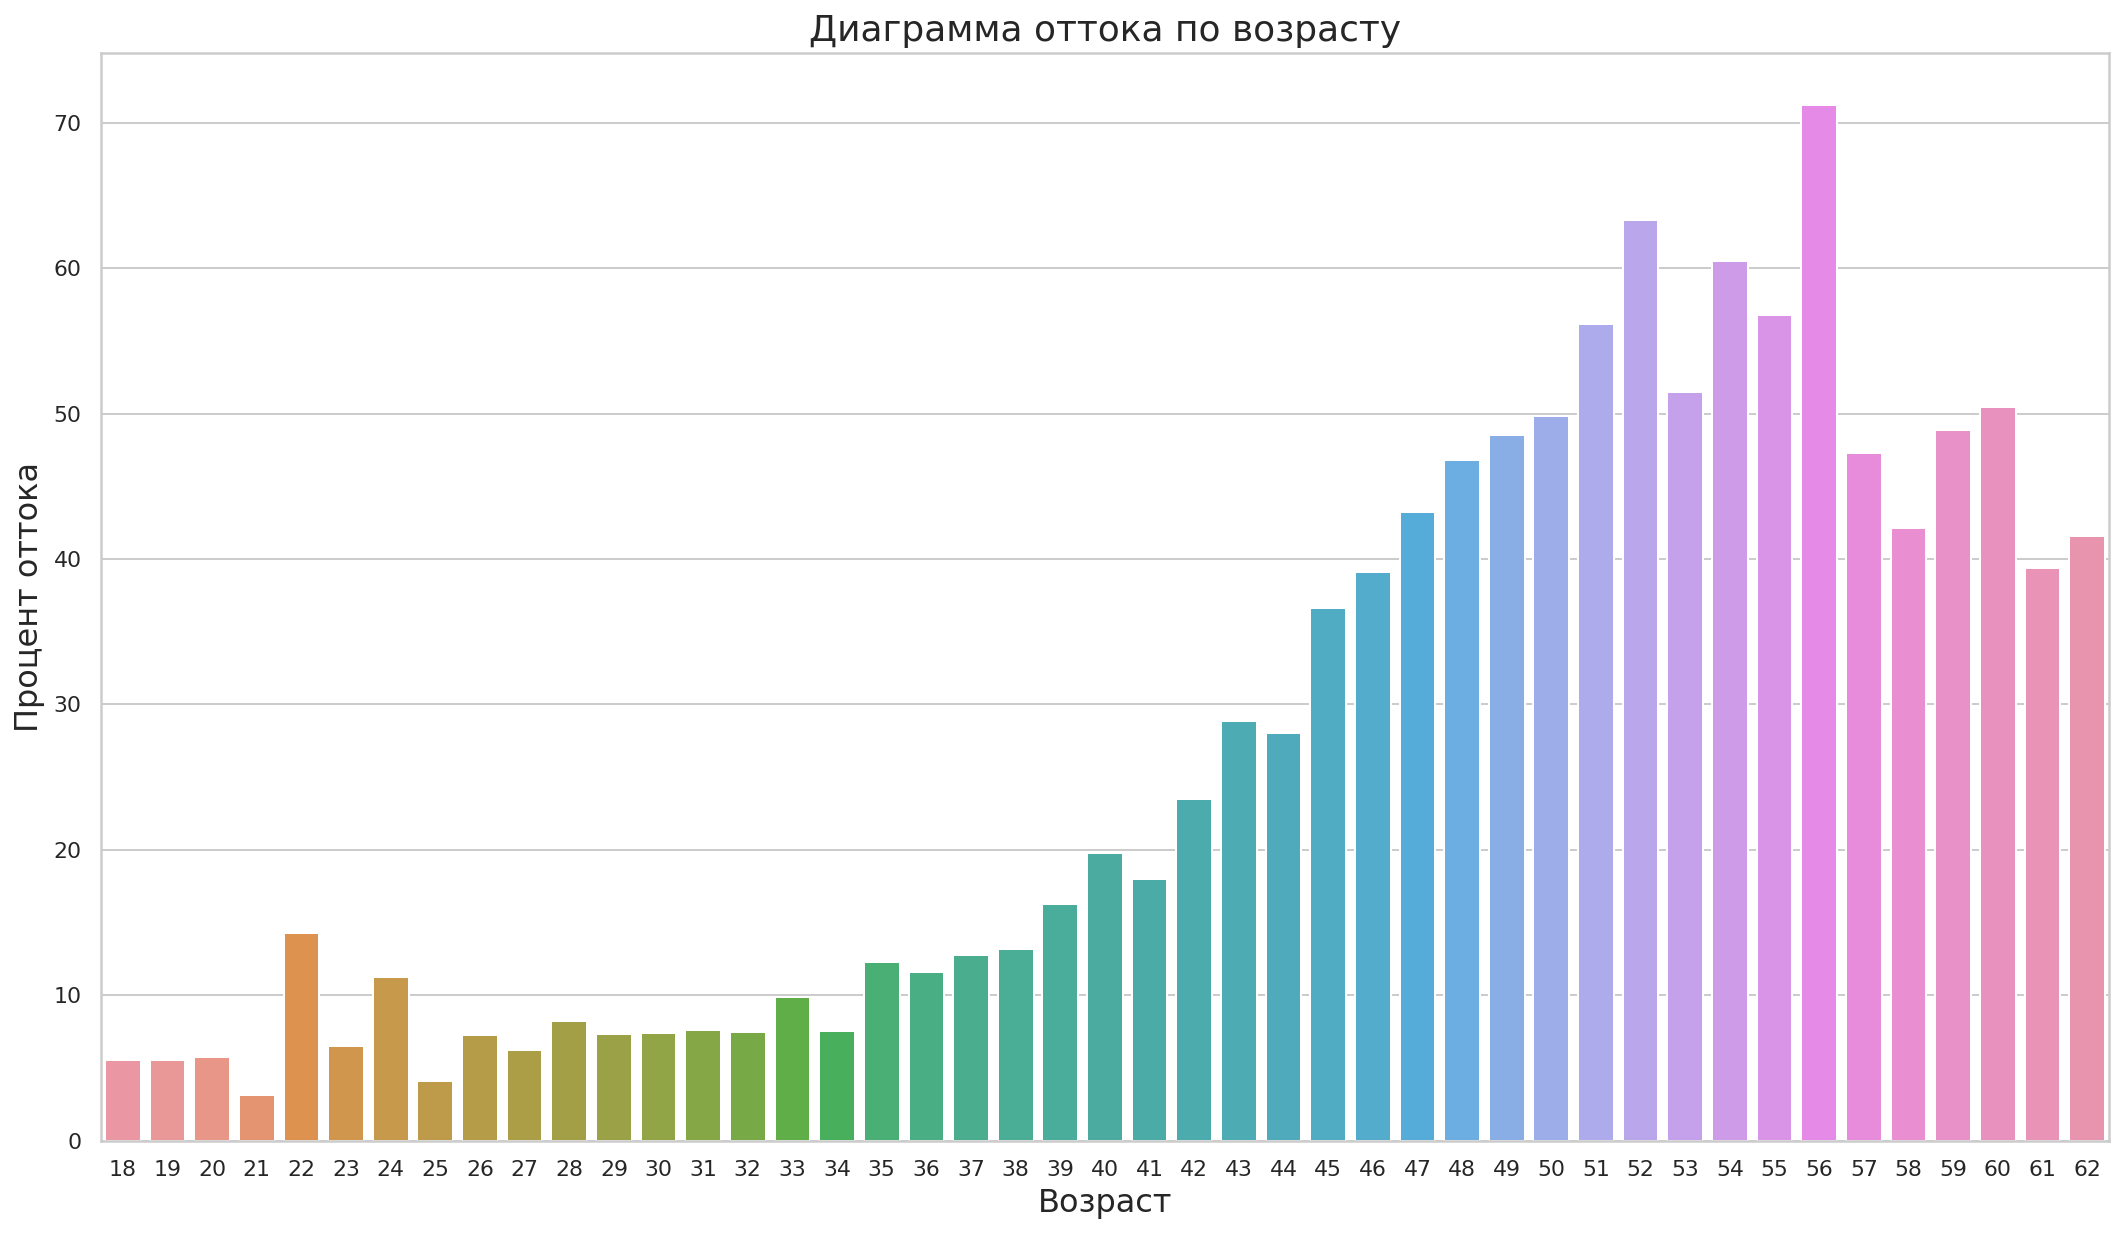

In [37]:
# построим график для визуализации выборки

plt.figure(figsize=(18,10))

sns.barplot(x=age_churn_ratio['age'],\
            y=age_churn_ratio['ratio'], ci=None);
plt.title('Диаграмма оттока по возрасту', fontsize=18);
plt.xlabel('Возраст', fontsize=16);
plt.ylabel('Процент оттока', fontsize=16);

Можно выделить отдельный портрет с оттоком выше 50%. Он совпадает с пиком у женщин, обнаруженным чуть выше.

Портрет №2: **Возраст 51-56**
- Пол: любой


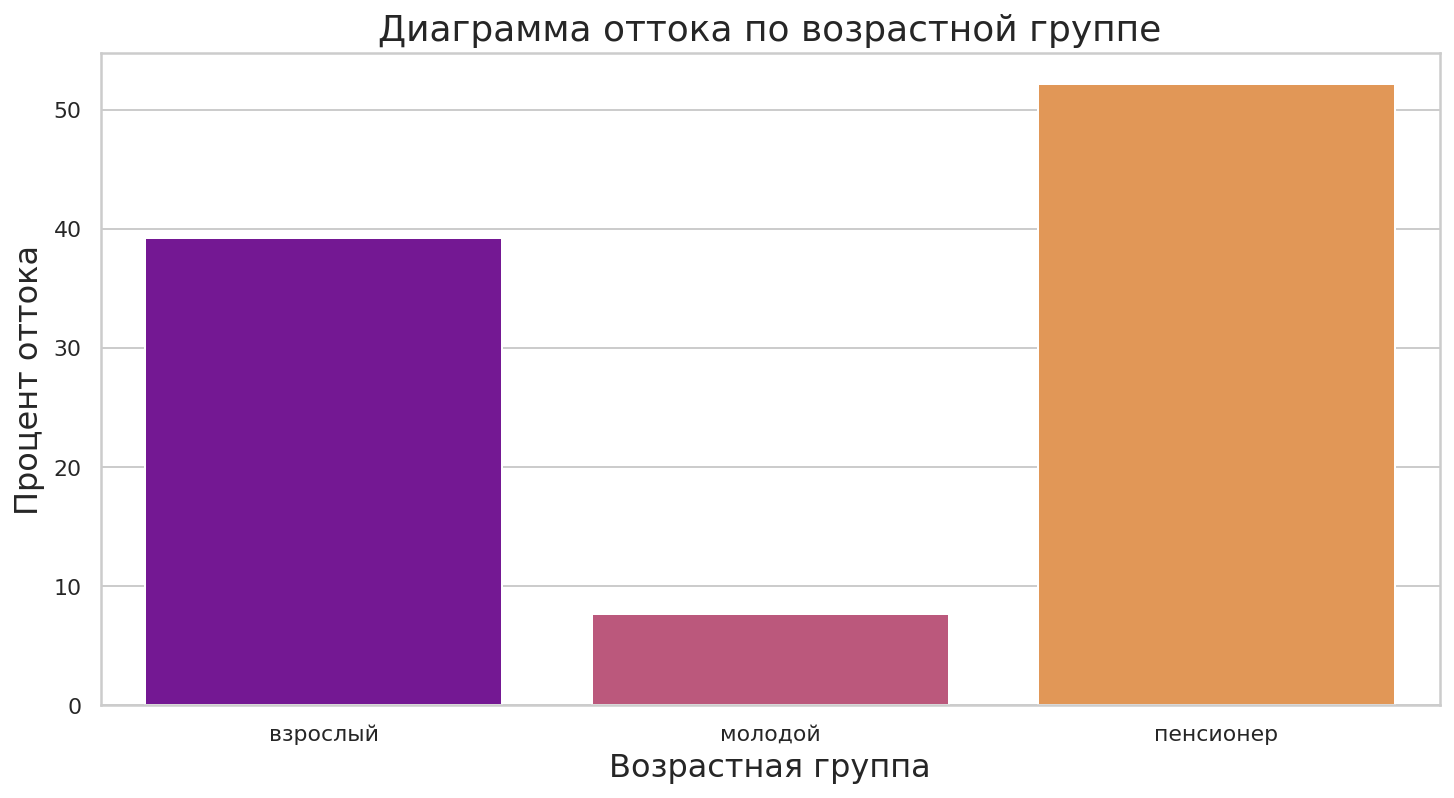

In [38]:
# построим график для визуализации выборки
plt.figure(figsize=(12,6))

sns.barplot(x=age_churn_ratio['age_group'], y=age_churn_ratio['ratio'], ci=None, palette='plasma');
plt.title('Диаграмма оттока по возрастной группе', fontsize=18);
plt.xlabel('Возрастная группа', fontsize=16);
plt.ylabel('Процент оттока', fontsize=16);

In [39]:
# статистики по возрастной группе
df_fil.drop(columns='userid').groupby('age_group').mean().T

age_group,взрослый,молодой,пенсионер
score,650.63,650.81,651.35
gender,0.54,0.56,0.00
age,43.56,30.01,62.00
objects,4.99,5.05,5.83
balance,119528.00,120046.73,123326.43
products,1.50,1.54,1.48
creditcard,0.70,0.72,0.52
loyalty,0.50,0.51,0.65
estimated_salary,99978.49,100015.05,100700.61
churn,0.28,0.08,0.52


- Очень хороший, низкий показатель оттока в группе молодых клиентов;
- 52% оттока в группе пенсионеров

Инсайт: в группе пенсионеров встречаются в подавляющем большинстве женщины. Средний возраст такого клиента – 62 года. Интересно, что показатель активности при этом высокий, выше среднего, 65%. При этом кредитные карты есть у меньшего количества, чем в среднем.
Вероятно, в период перед пенсией женщины начинают разбираться со своими банковскими счетами и продуктами, увеличивают активность и ищут выгодные предложения. Похоже, что молодые пенсионерки – это самая рисковая для банка возрастная группа. Возможно, в банке заказчика нет разницы в возрасте для пенсионных программ и все льготы начинаются с 65 лет, а в других банках учитывают пол клиента и пенсионеркам дают льготные ставки с 62 лет.

Выделять отдельный портрет не будем, но передадим информацию менеджерам, чтобы присмотрелись к данной группе.

#### По количеству продуктов


Так как клиенты с количеством продуктов 4 попали под фильтр при очистке от выбросов, посмотрим картину по сырому датасету:

In [40]:
# расчет доли оттока по возрастным группам
products_churn_ratio = df.groupby(['products','gender', 'age']).agg({'churn':'sum', 'userid':'count'})\
                  .rename(columns={'userid': 'total'})\
                  .sort_values(by='total', ascending=False).reset_index()
products_churn_ratio['ratio'] = products_churn_ratio['churn'] / products_churn_ratio['total'] * 100


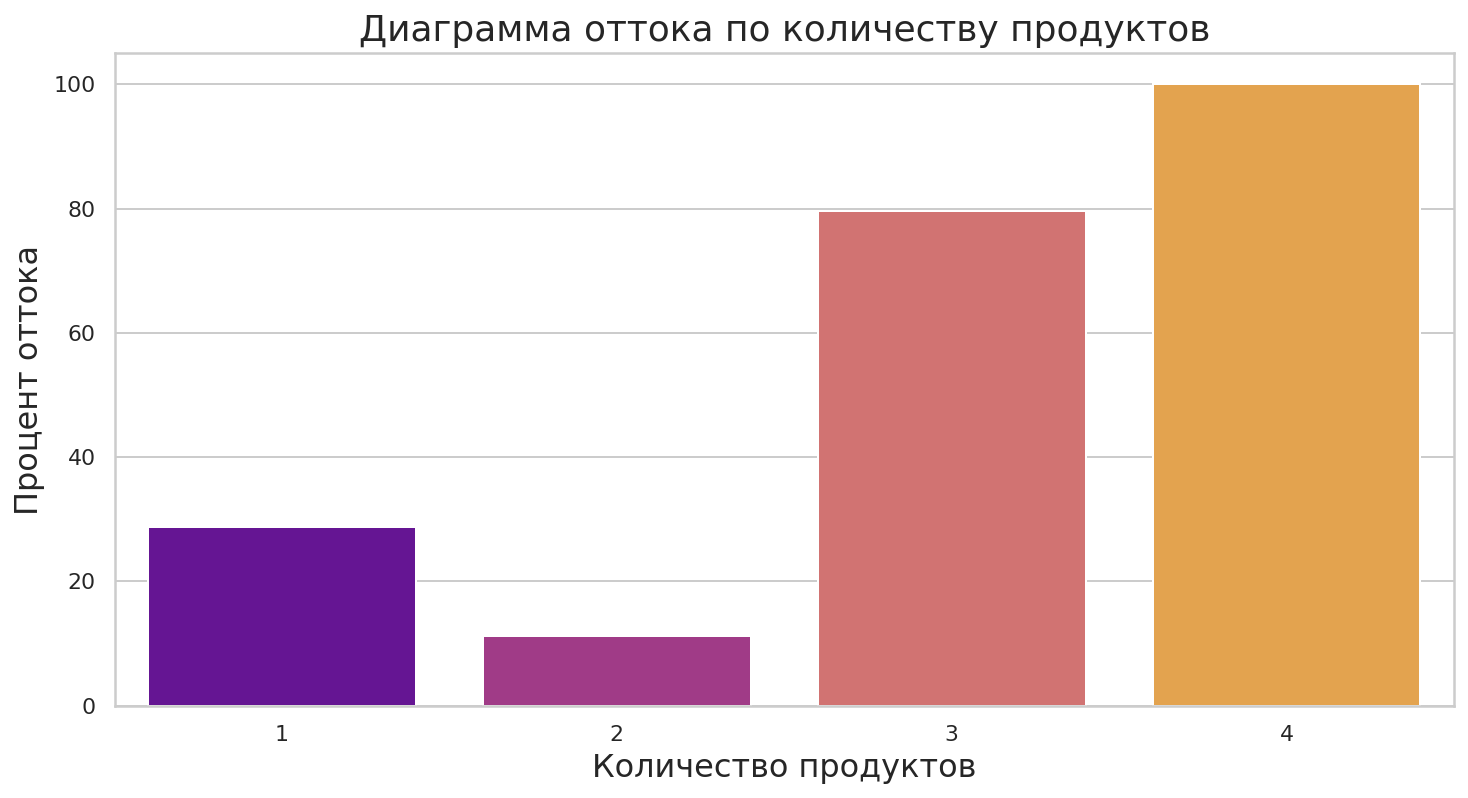

In [41]:
# построим график для визуализации выборки
plt.figure(figsize=(12,6))

sns.barplot(x=products_churn_ratio['products'], y=products_churn_ratio['ratio'], ci=None, palette='plasma');
plt.title('Диаграмма оттока по количеству продуктов', fontsize=18);
plt.xlabel('Количество продуктов', fontsize=16);
plt.ylabel('Процент оттока', fontsize=16);

Видим очень высокий процент оттока у клиентов с 3 и 4 продуктами.

Портрет №3: **Пользователи 3 и 4 продуктов**


#### По городам


Общий обзор по городам:

In [42]:
# группировка средних по городу и оттоку
df_fil[cat_metrics].groupby(['city','churn']).mean()

gender  creditcard  loyalty  products  objects
city           churn                                                
Ростов Великий 0        0.56        0.72     0.55      1.55     5.01
               1        0.45        0.71     0.36      1.37     5.06
Рыбинск        0        0.59        0.70     0.55      1.55     5.11
               1        0.44        0.66     0.34      1.47     4.65
Ярославль      0        0.57        0.71     0.53      1.54     5.01
               1        0.44        0.71     0.36      1.39     4.95

Инсайт: в Рыбинске в группе оттока клиентов с кредитными картами на 5% меньше, чем в среднем по базе, а сам отток на 2% меньше среднего по базе. Возможно, что в этом городе могут уходить люди из-за невозможности открыть кредитную карту, эту информацию нужно проверить менеджерам.

- Ростов Великий и Ярославль показывают примерно одинаковые значения, различия не более 1% от средних показателей всего датасета.

In [43]:
# группировка медиан по городу и оттоку
df_fil[cont_metrics].groupby(['city','churn']).median()

score   age   balance  estimated_salary
city           churn                                         
Ростов Великий 0     653.00 36.00 120599.38         103573.96
               1     647.00 45.00 118815.36          95812.62
Рыбинск        0     651.00 36.00 119790.99          98676.47
               1     648.00 44.00 116226.83         108987.25
Ярославль      0     654.00 35.00 119416.20          98358.45
               1     645.50 44.50 122819.32         100852.82

Инсайт: в Ярославле в группу с оттоком попадают клиенты с балансом чуть выше среднего, при этом он больше, чем в группе без оттока.
 предположительно, клиенты из Ярославля могут ожидать премиального обслуживания, имея баланс счета выше среднего, не получая его – уходят в отток.

Большое количество клиентов без оттока, но с пропущенными значениями в показателе Баланс в городе Рыбинск. Вероятно, там имеют место быть технические проблемы, это нужно передать заказчику.

In [44]:
# расчет доли оттока по городам
city_churn_ratio = df_fil.groupby('city').agg({'churn':'sum', 'userid':'count'})\
                  .rename(columns={'userid': 'total'})\
                  .sort_values(by='total', ascending=False).reset_index()
city_churn_ratio['ratio'] = city_churn_ratio['churn'] / city_churn_ratio['total'] * 100
city_churn_ratio

,city,churn,total,ratio
0,Ярославль,730,4766,15.32
1,Ростов Великий,758,2381,31.84
2,Рыбинск,371,2351,15.78


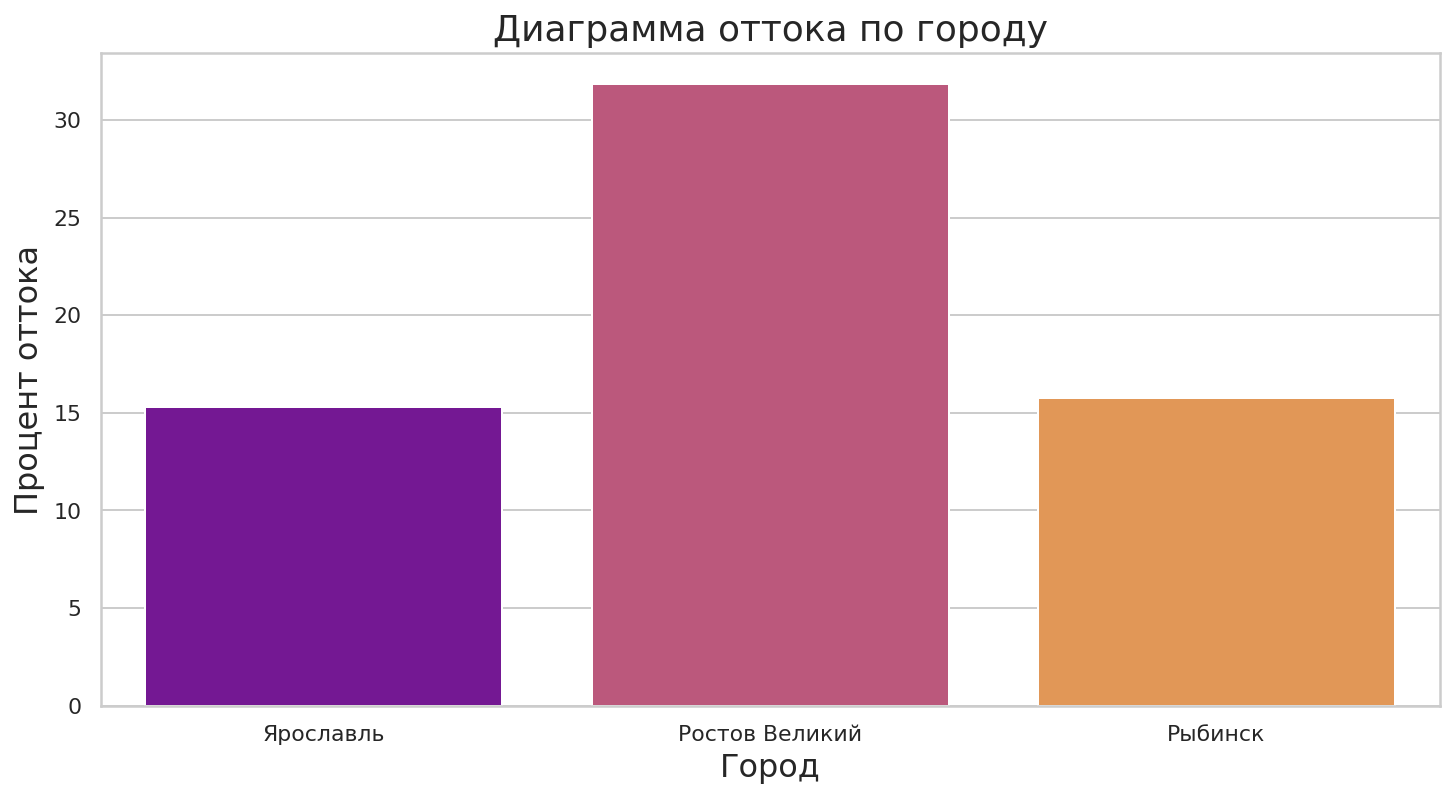

In [45]:
# построим график для визуализации выборки
plt.figure(figsize=(12,6))

sns.barplot(x=city_churn_ratio['city'], y=city_churn_ratio['ratio'], ci=None, palette='plasma');
plt.title('Диаграмма оттока по городу', fontsize=18);
plt.xlabel('Город', fontsize=16);
plt.ylabel('Процент оттока', fontsize=16);

Самый высокий процент оттока – в Ростове Великом (31.6%). Это в 2 раза выше, чем в других городах банка. Стоит обратить внимание на этот город особенно.

Другие города – с долей оттока ниже среднего.

##### Отток по Ярославлю

In [46]:
# выборка клиентов с оттоком по Ярославлю
churn_yar = churn_total.query('city == "Ярославль"')

# статистика выборки
churn_yar.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,730.00,15735267.52,72816.03,15608987.00,15670049.50,15737242.00,15798344.75,15857582.00
score,730.00,643.93,97.45,405.00,570.00,645.50,711.00,850.00
gender,730.00,0.44,0.50,0.00,0.00,0.00,1.00,1.00
age,730.00,44.39,9.08,18.00,38.00,44.50,51.00,62.00
objects,730.00,4.95,2.93,0.00,2.00,5.00,7.00,10.00
balance,416.00,121217.79,34512.58,42157.08,97413.33,122819.32,146211.70,192122.84
products,730.00,1.39,0.68,1.00,1.00,1.00,2.00,3.00
creditcard,730.00,0.71,0.45,0.00,0.00,1.00,1.00,1.00
loyalty,730.00,0.36,0.48,0.00,0.00,0.00,1.00,1.00
estimated_salary,730.00,102224.22,57254.95,123.07,55758.80,100852.82,153287.70,199378.58


Из 4 влияющих на отток признаков будет рассматривать в разрезе пола и возраста, так как нулевая активность и количество продуктов = 1, похоже, в группе оттока везде одни и те же.

In [47]:
# расчет доли оттока по возрасту
yar_churn_ratio = df_fil.query('city == "Ярославль"').groupby(['gender', 'age'])\
                  .agg({'churn':'sum', 'age':'count'})\
                  .rename(columns={'age': 'total'})\
                  .sort_values(by='total', ascending=False).reset_index()
yar_churn_ratio['ratio'] = yar_churn_ratio['churn'] \
                          / yar_churn_ratio['total'] * 100

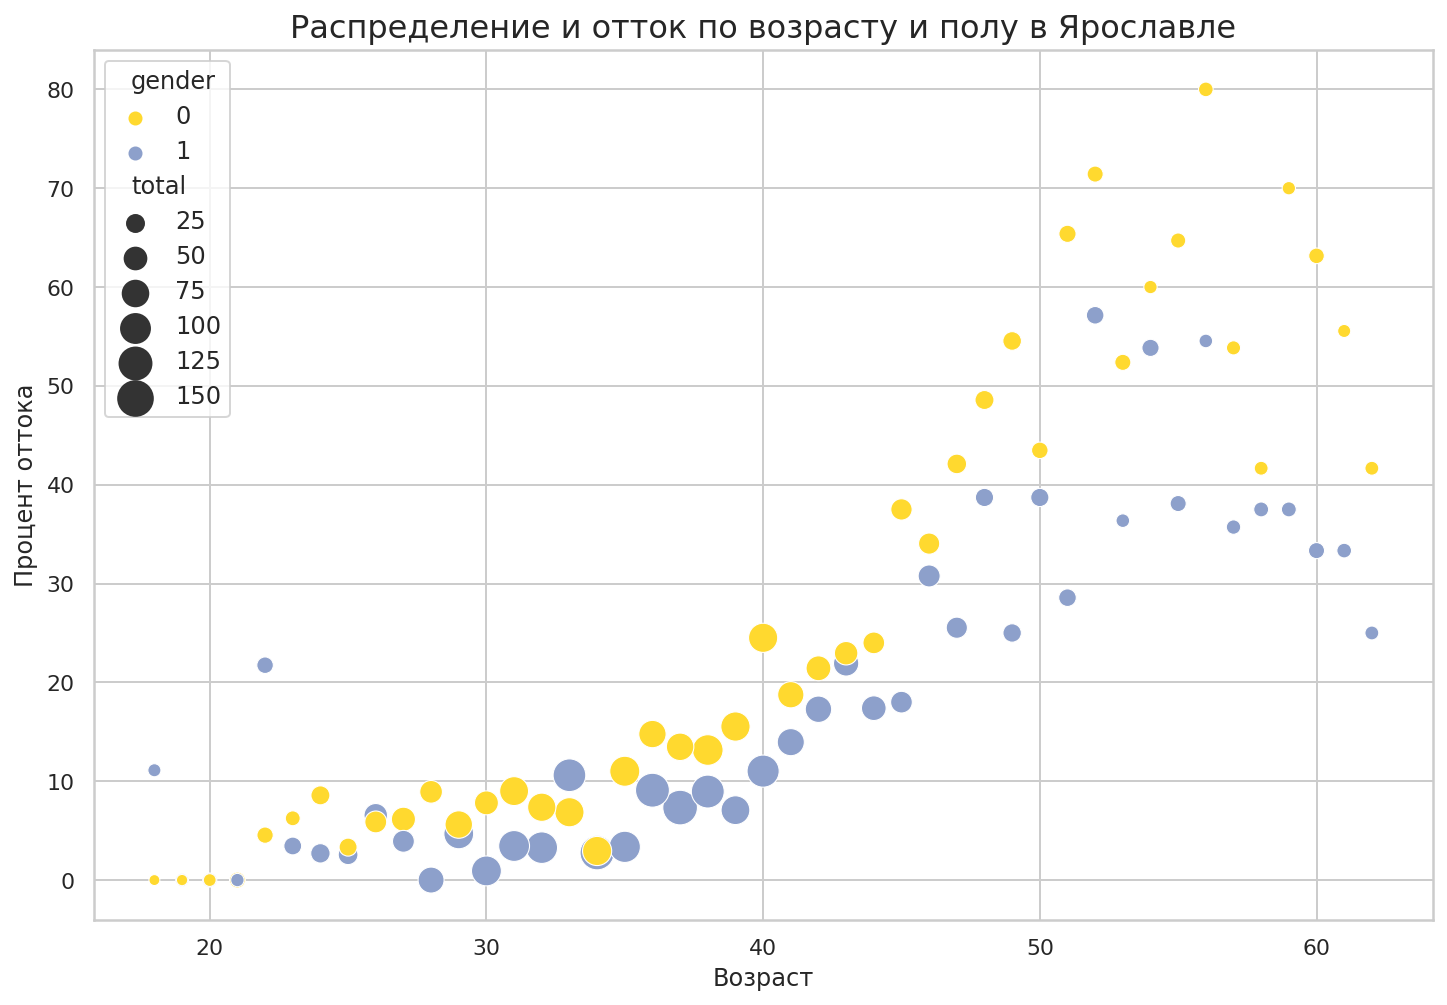

In [48]:
# вывод диаграммы распределения
fig = plt.figure(figsize=(12,8))

plt.xlabel('Возраст')
plt.ylabel('Процент оттока')
plt.title('Распределение и отток по возрасту и полу в Ярославле', fontsize=16)
ax = sns.scatterplot(data=yar_churn_ratio, x='age', y='ratio',\
                     hue='gender', palette='Set2_r', size='total',\
                     sizes=(30, 300))
plt.show();

730 клиентов в оттоке из 4766. Самый низкий показатель оттока среди трёх рассматриваемых городов -  всего 15.32%.

На диаграмме видим, что основной рост процента оттока идет от 40 лет. 
При этом процент оттока у женского пола в этом городе практически всегда выше – явно видно разделение женской и мужской линии.
Большая часть клиентов в оттоке попадает в возрастной диапазон 30-45 лет.
В целом, портрет города соответствует среднему портрету оттока, выделять в отдельный портрет не нужно.


##### Отток по Ростову Великому

In [49]:
# выборка клиентов без оттока по Ростову Великому
churn_ros = churn_total.query('city == "Ростов Великий"')

# статистика выборки
churn_ros.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,758.00,15732260.68,74008.75,15608766.00,15669998.00,15729654.00,15797166.00,15858392.00
score,758.00,648.60,99.52,395.00,580.00,647.00,726.75,850.00
gender,758.00,0.45,0.50,0.00,0.00,0.00,1.00,1.00
age,758.00,44.09,8.74,19.00,38.00,45.00,50.00,62.00
objects,758.00,5.06,2.99,0.00,3.00,5.00,8.00,10.00
balance,758.00,120267.48,19399.90,62389.03,107345.18,118815.36,132783.58,181461.48
products,758.00,1.37,0.67,1.00,1.00,1.00,2.00,3.00
creditcard,758.00,0.71,0.45,0.00,0.00,1.00,1.00,1.00
loyalty,758.00,0.36,0.48,0.00,0.00,0.00,1.00,1.00
estimated_salary,758.00,98407.92,59086.22,11.58,47003.51,95812.62,149395.91,199808.10


In [50]:
# расчет доли оттока для Ростова Великого
ros_churn_ratio = df_fil.query('city == "Ростов Великий"').groupby(['gender', 'age'])\
                  .agg({'churn':'sum', 'age':'count'})\
                  .rename(columns={'age': 'total'})\
                  .sort_values(by='total', ascending=False).reset_index()
ros_churn_ratio['ratio'] = ros_churn_ratio['churn'] \
                          / ros_churn_ratio['total'] * 100

ros_churn_ratio.groupby(['gender'])\
                  .agg({'total':'sum', 'ratio':'median'})

,total,ratio
gender,,
0,1134,37.50
1,1247,25.86


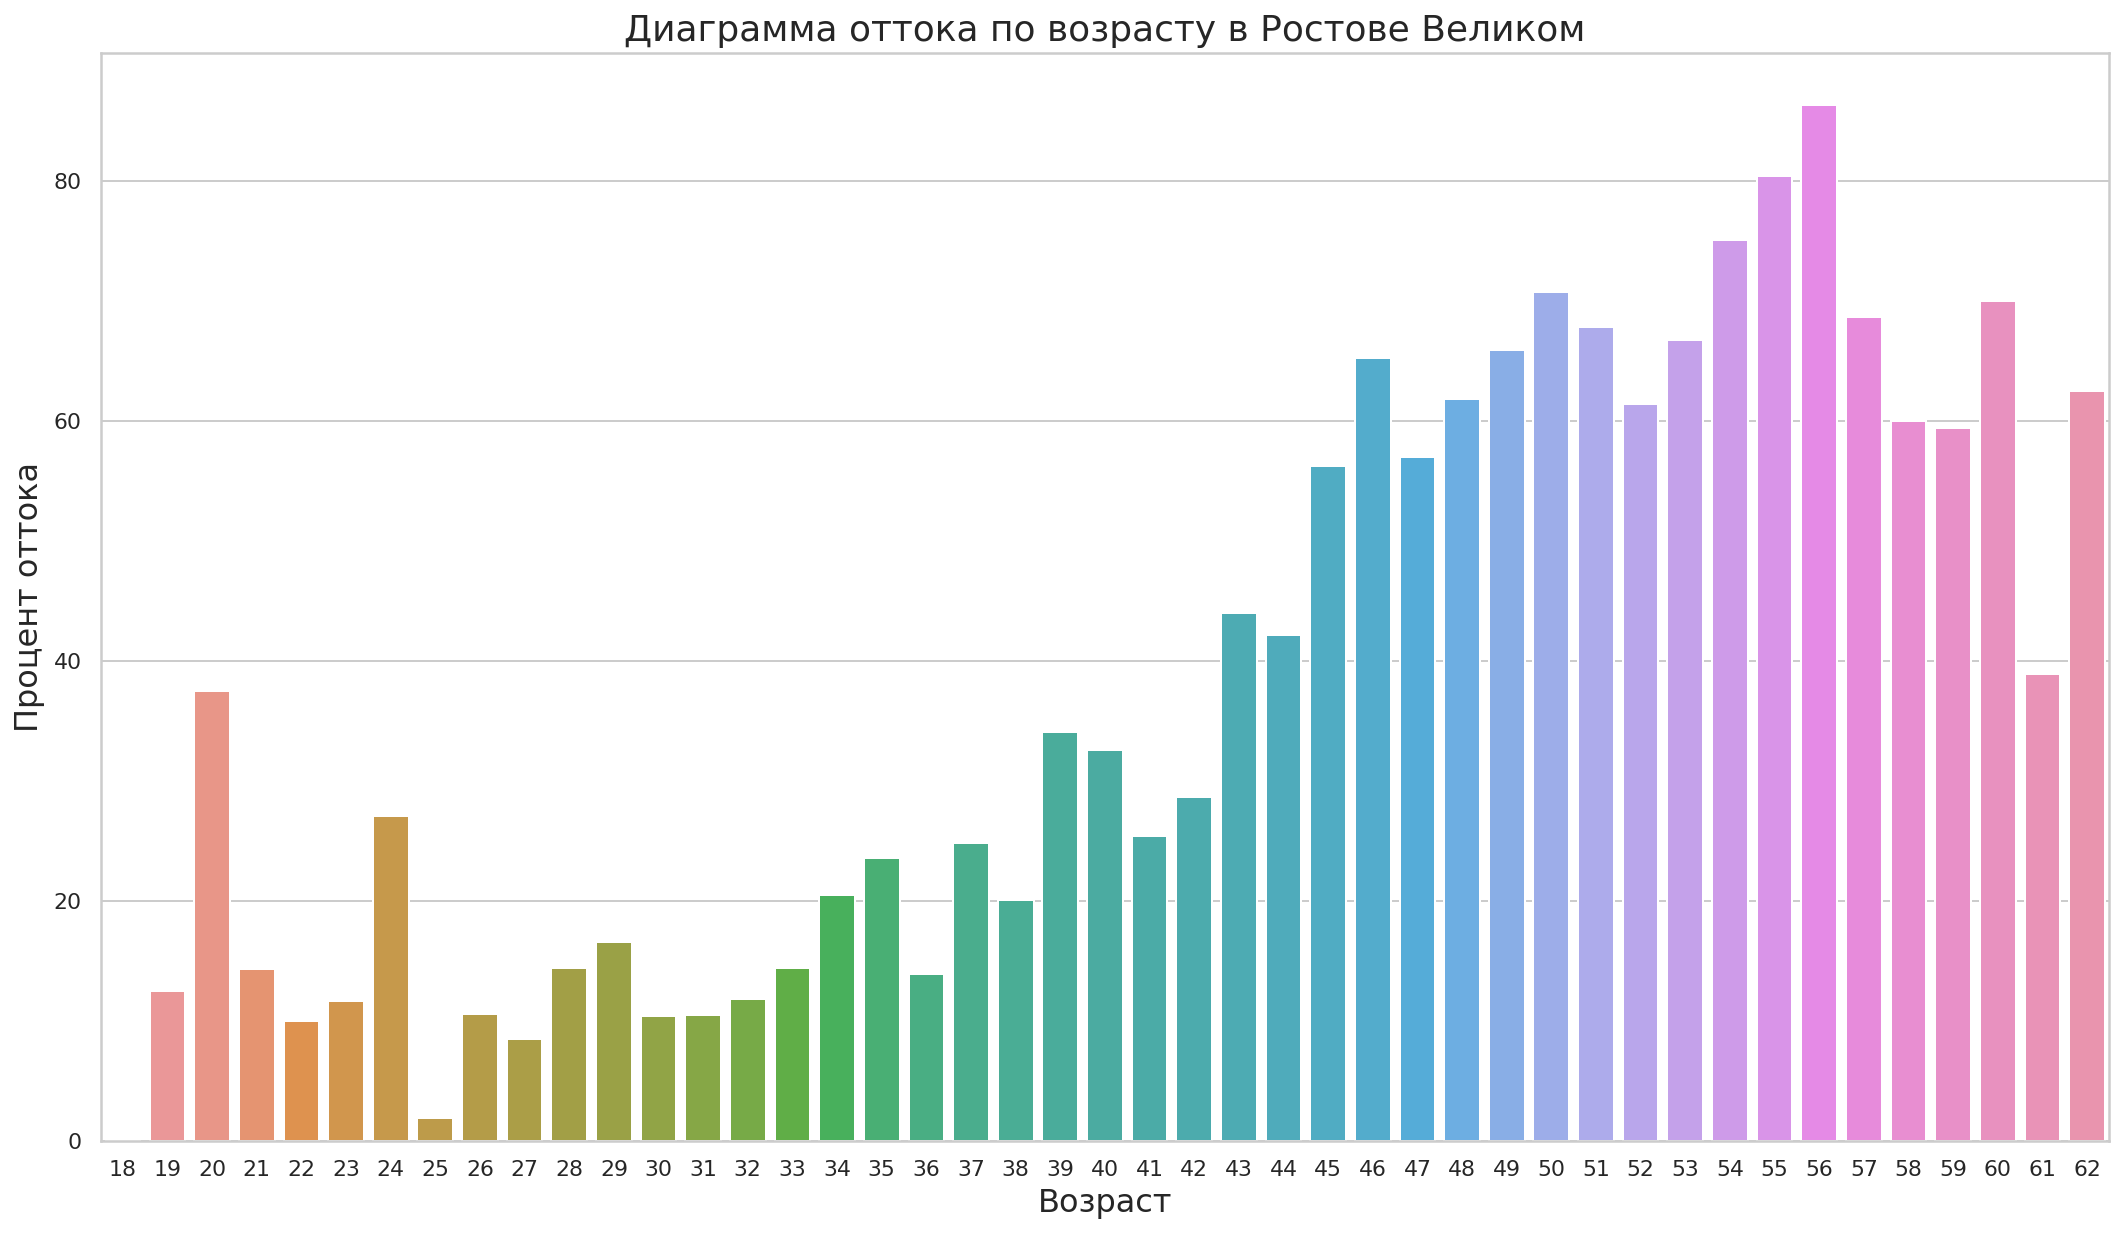

In [51]:
# построим график для визуализации выборки

plt.figure(figsize=(18,10))

sns.barplot(x=ros_churn_ratio['age'],\
            y=ros_churn_ratio['ratio'], ci=None);
plt.title('Диаграмма оттока по возрасту в Ростове Великом', fontsize=18);
plt.xlabel('Возраст', fontsize=16);
plt.ylabel('Процент оттока', fontsize=16);

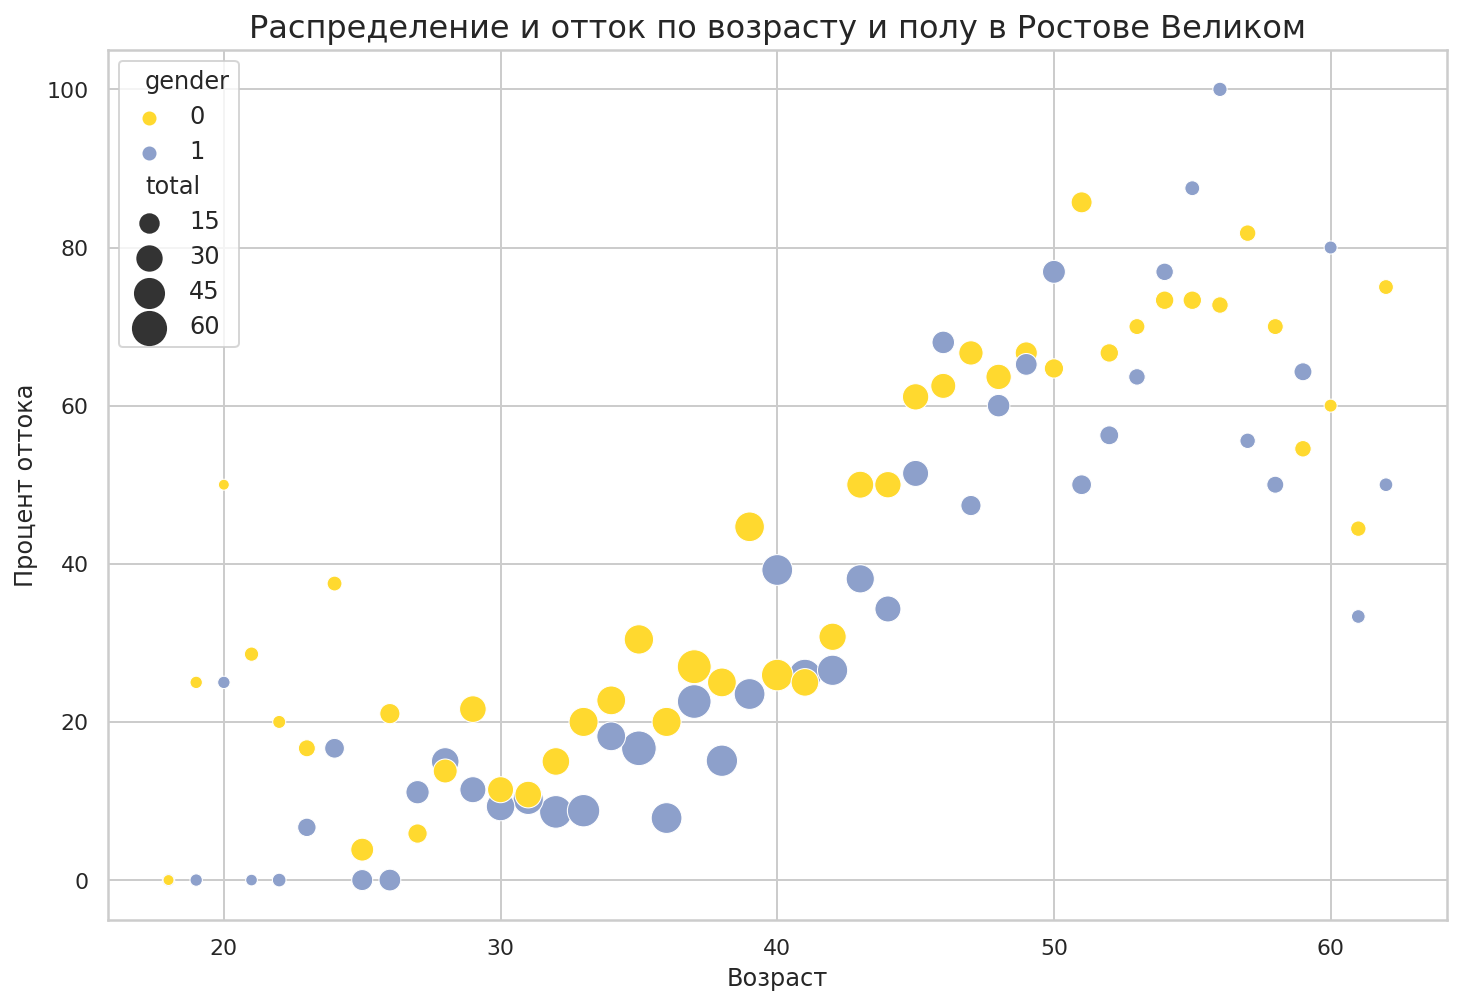

In [52]:
# вывод диаграммы распределения
fig = plt.figure(figsize=(12,8))

plt.xlabel('Возраст')
plt.ylabel('Процент оттока')
plt.title('Распределение и отток по возрасту и полу в Ростове Великом', fontsize=16)
ax = sns.scatterplot(data=ros_churn_ratio, x='age', y='ratio',\
                     hue='gender', palette='Set2_r', size='total',\
                     sizes=(30, 300))
plt.show();

758 клиентов в оттоке из 2381. Самый высокий показатель оттока среди трёх городов – 31.84%.

Распределение с разрезе пола и возраста здесь отличается от Ярославля: в отток здесь уходят более молодые клиенты, при этом их число довольно большое. 

Отток выше 50% начинается с возраста 45+, при этом мужчины и женщины в оттоке распределены довольно равномерно, привязка к гендеру не так выражена. 

Инсайт: в Ростове Великом в процент оттока выше среднего попадают даже клиенты младше 25. Вероятно, в этом банке нужно обратить внимание на провеку качества обслуживания, так как такое поведение не свойственно для других городов.

Портрет №4: **Клиенты из Ростова Великого 45+**
- Пол: любой
- Возраст: 45+

##### Отток по Рыбинску

In [53]:
# выборка клиентов с оттоком по Рыбинску
churn_ryb = churn_total.query('city == "Рыбинск"')

# статистика выборки
churn_ryb.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,371.00,15730297.09,69933.87,15608442.00,15674447.50,15728835.00,15788016.50,15857831.00
score,371.00,650.69,94.99,383.00,586.50,648.00,719.00,850.00
gender,371.00,0.44,0.50,0.00,0.00,0.00,1.00,1.00
age,371.00,43.26,9.26,18.00,36.50,44.00,50.00,62.00
objects,371.00,4.65,2.82,0.00,2.00,5.00,7.00,10.00
balance,218.00,117361.84,36592.86,41473.33,88900.21,116226.83,143663.04,194532.66
products,371.00,1.47,0.71,1.00,1.00,1.00,2.00,3.00
creditcard,371.00,0.66,0.47,0.00,0.00,1.00,1.00,1.00
loyalty,371.00,0.34,0.47,0.00,0.00,0.00,1.00,1.00
estimated_salary,371.00,102743.78,57288.45,417.41,54322.29,108987.25,152523.70,199304.74


In [54]:
# расчет доли оттока по возрасту
ryb_churn_ratio = df_fil.query('city == "Рыбинск"').groupby(['gender', 'age'])\
                  .agg({'churn':'sum', 'age':'count'})\
                  .rename(columns={'age': 'total'})\
                  .sort_values(by='total', ascending=False).reset_index()
ryb_churn_ratio['ratio'] = ryb_churn_ratio['churn'] \
                          / ryb_churn_ratio['total'] * 100

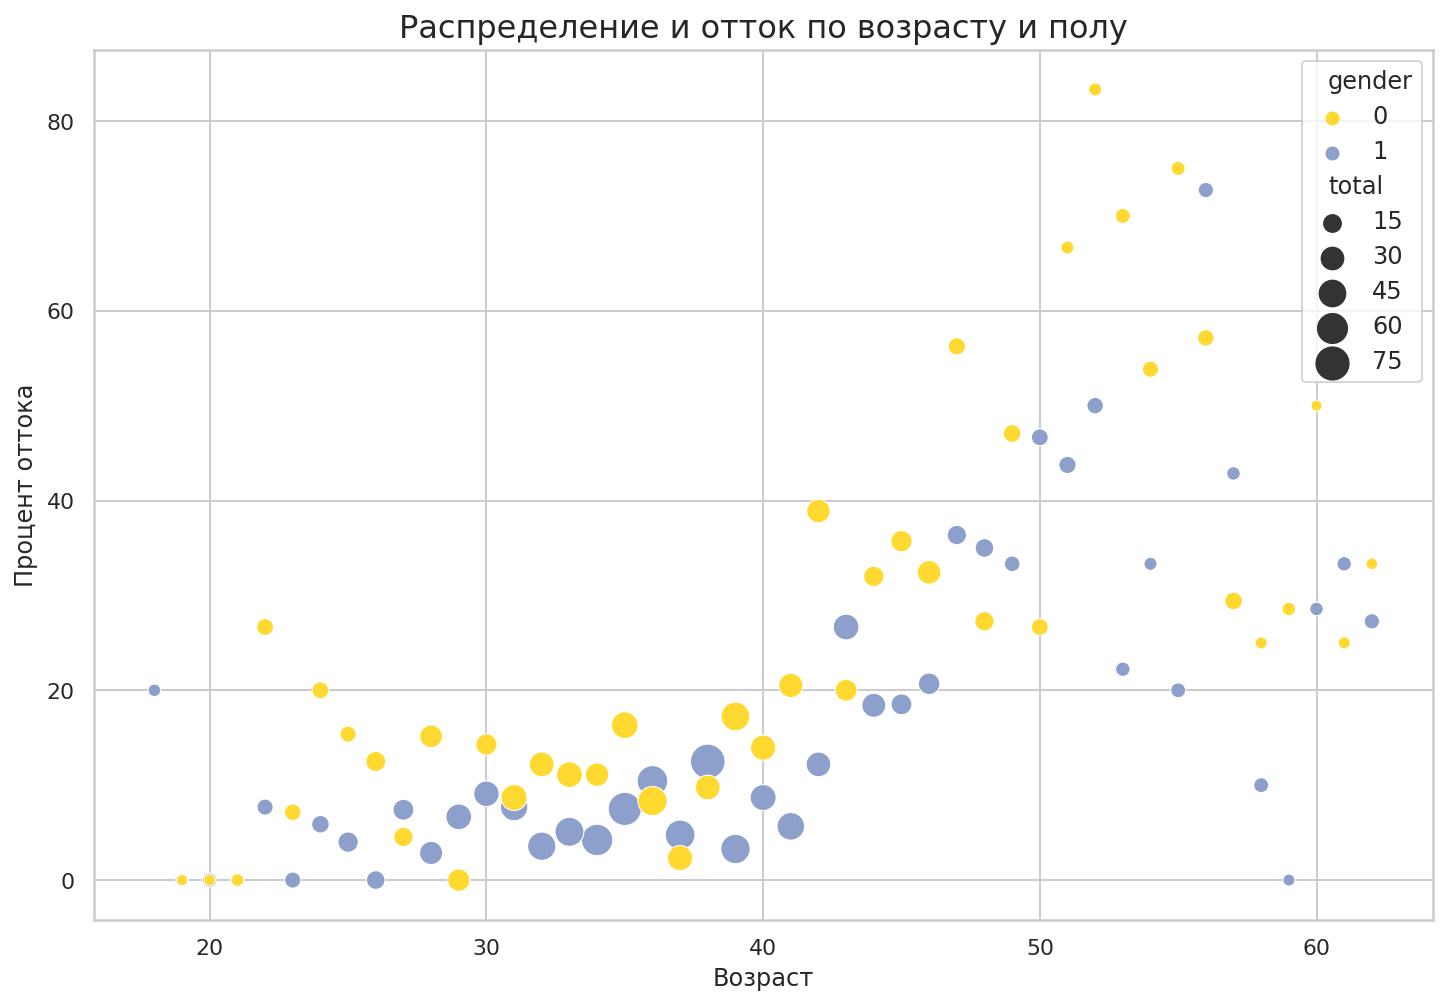

In [55]:
# вывод диаграммы распределения
fig = plt.figure(figsize=(12,8))

plt.xlabel('Возраст')
plt.ylabel('Процент оттока')
plt.title('Распределение и отток по возрасту и полу', fontsize=16)
ax = sns.scatterplot(data=ryb_churn_ratio, x='age', y='ratio',\
                     hue='gender', palette='Set2_r', size='total',\
                     sizes=(30, 300))
plt.show();

371 клиент в оттоке из 2351. Низкий показатель оттока, почти как в Ярославле – 15.78%.

Здесь в отток выше 50% попадает меньше всего клиентов. Выделять в портет нет необходимости.


### Приоритезация портретов

Зададим описания портретов и расчитаем их важность по суммарному количеству клиентов и доле оттока.



In [56]:
# задание портретов по нескольким признакам
churn_portraits = [
    ("Женщины 45+ с 1 продуктом", 'age >= 45 and gender == 0 and products == 1'),
    ("Возраст 51-56", '(56 >= age >= 51)'),
    ("Пользователи 3 и 4 продуктов", 'products > 2'),
    ("Клиенты из Ростова Великого 45+", 'city == "Ростов Великий" and age >= 45'),
    ("Идеальный клиент", 'age <=37 and gender == 1 and products == 2 and loyalty == 1')
]



# расчет количества клиентов и процента оттока
dfs_temp = []
for text, query in churn_portraits:
    result = df_grouped.query(query)\
              .agg({'churn':['mean', 'count']}).T
    result.index = [text]
    dfs_temp.append(result)

# расчет и вывод результатов по важности
df_temp = pd.concat(dfs_temp)
df_temp['churn_suplus'] = df_temp['mean'] - df_grouped.churn.mean()
df_temp['idx'] = df_temp['count'] * df_temp['churn_suplus']
df_temp.sort_values('idx', ascending=False).drop(['idx','mean'],axis=1)

,count,churn_suplus
Клиенты из Ростова Великого 45+,688.00,0.41
Женщины 45+ с 1 продуктом,665.00,0.40
Пользователи 3 и 4 продуктов,326.00,0.66
Возраст 51-56,531.00,0.40
Идеальный клиент,757.00,-0.19


### Вывод по шагу

Мы рассмотрели клиентов по различным признакам датасета – с оттоком и без.

Выявлены закономерности в портрете клиента, который склонен покинуть банк:
- Чаще женщина
- Возраст старше 44 лет
- Использует 1 банковский продукт
- Не активна

В трёх городах есть незначительная разница в портретах, но Ростов Великий показывает аномально большой процент оттока, в 2 раза выше остальных городов.


Также выявлен предположительный портрет "идеального клиента", к которому можно стремиться (например, использовать в таргетированной рекламе банка).

- Мужчина
- Возраст до 37 лет
- Использует 2 банковских продукта
- Активен


Признаки, коррелирующие с оттоком:

- пол
- возраст
- активность
- количество банковских продуктов

Выделены портреты клиентов, у которых отток выше 39%:

- Портрет №1: **Женщины 45+ с 1 продуктом**
- Портрет №2: **Возраст 51-56**
- Портрет №3: **Пользователи 3 и 4 продуктов**
- Портрет №4: **Клиенты из Ростова Великого 45+**

---

## Проверка гипотез


- Формулирование статистических гипотез на основе имеющихся данных
- Проверка гипотез:
> 1. о различии дохода между теми клиентами, которые ушли и теми, которые остались;
> 2. о влиянии другого признака на отток (будет сформулирована после составления портретов)
- Вывод по шагу

### Формулирование статистических гипотез на основе имеющихся данных

В предыдущем шаге мы обнаружили, что есть 4 признака, имеющих корреляцию с целевой переменной. Поэтому проверим 4 гипотезы о различии клиентов по:

-  доходу;
-  среднему возрасту;
-  полу;
-  активности.

### Проверка данных на нормальность


Проверим размеры выборок, чтобы выбрать статистический критерий для проверки гипотез:

In [57]:
print('Размеры выборок: в оттоке - {}, без оттока - {}'.\
      format(len(churn_total), len(no_churn_total)))

Размеры выборок: в оттоке - 1859, без оттока - 7639


Размеры выборок значительно отличаются.


Проведем тест Шапиро-Уилка на одной из выборок, которые будем использовать в гипотезах.

За уровень статистической значимости примем 0.05 (5%) - это вероятность того, что мы сочли различия существенными, а они на самом деле случайны. В промышленной статистике часто считают достаточным 5% уровень значимости, при более ответственных исследованиях уровень значимости может быть уменьшен до 1% или даже до 0,1%.



In [58]:
alpha = 0.05  # критический уровень статистической значимости

results = st.shapiro(churn_total['estimated_salary'])
p_value = results[1]  # второе значение в массиве результатов (с индексом 1) - p-value

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

p-значение:  3.556933589735376e-24
Отвергаем нулевую гипотезу: распределение не нормально


Так как распределение не нормальное, для проверки гипотез будем использовать критерий Манна-Уитни и z-критерий Фишера.

### Гипотеза №1: о различии доходов у клиентов с оттоком и без оттока

- $H_0$: доходы клиентов с оттоком и без оттока не различаются
- $H_1$: доходы клиентов с оттоком и без оттока различаются

Нулевой гипотезой считается принимаемое по умолчанию предположение о том, что не существует связи между двумя наблюдаемыми событиями.

In [59]:
# создание выборок с двумя группами оттока и доходом
no_churn_salary = no_churn_total['estimated_salary']
churn_salary = churn_total['estimated_salary']

In [60]:
alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu(no_churn_salary, churn_salary)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  0.5191888719885412
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


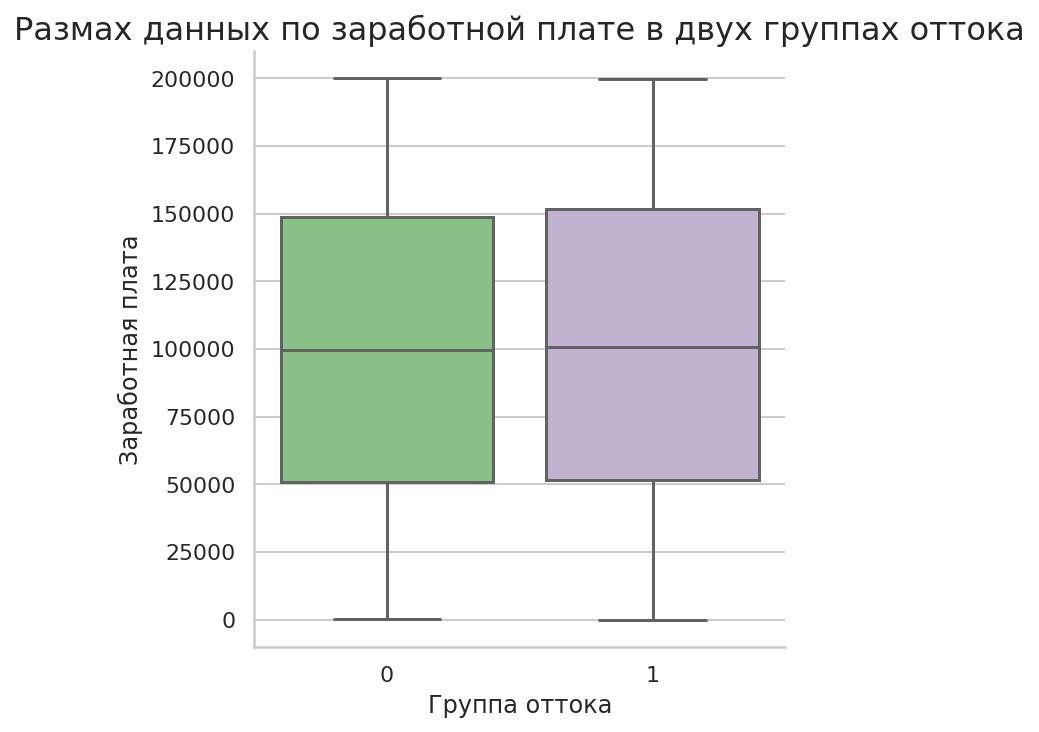

,estimated_salary
churn,
0,99692.65
1,100722.72


In [61]:
# группка групп по медиане расчетной заработной платы
churn_groups_salary = df_fil \
    .groupby(['churn']) \
    .agg({'estimated_salary' : 'median'})

# визуализация групп
sns.catplot(x='churn', y='estimated_salary', kind='box',\
            data=df_fil, orient='v', palette='Accent')
plt.title('Размах данных по заработной плате в двух группах оттока', fontsize=16)
plt.ylabel('Заработная плата')
plt.xlabel('Группа оттока')
plt.show();

churn_groups_salary

Проверена гипотеза о разнице в доходах у киентов в группах с оттоком и без оттока.


Построив группировку и визуализировав данные, видим, что рассчетная заработная плата практически равна в обеих групп.
 

**Вывод: не получилось отвергнуть нулевую гипотезу, вывод о различии доходов у групп без оттока и с оттоком сделать нельзя
.**

### Гипотеза №2: о различии среднего возраста клиентов в группах оттока и без оттока

- $H_0$: средний возраст клиентов в группах оттока и без оттока не различается
- $H_1$: средний возраст клиентов в группах оттока и без оттока различается

In [62]:
# создание выборок с двумя группами оттока и доходом
no_churn_age = no_churn_total['age']
churn_age = churn_total['age']

In [63]:
alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu(no_churn_age, churn_age)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  1.0650728451862203e-245
Отвергаем нулевую гипотезу: разница статистически значима


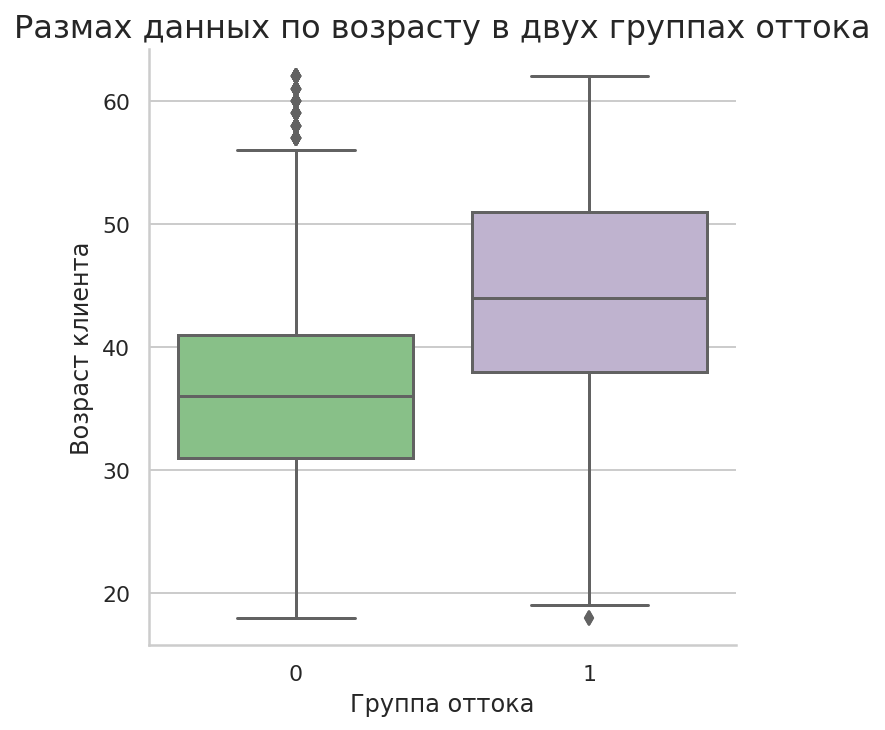

,age
churn,
0,36.00
1,44.00


In [64]:
# группка групп по медиане расчетной заработной платы
churn_groups_age = df_fil \
    .groupby(['churn']) \
    .agg({'age' : 'median'})

# визуализация групп
sns.catplot(x='churn', y='age', kind='box',\
            data=df_fil, orient='v', palette='Accent')
plt.title('Размах данных по возрасту в двух группах оттока', fontsize=16)
plt.ylabel('Возраст клиента')
plt.xlabel('Группа оттока')
plt.show();

churn_groups_age


Построив группировку и визуализировав данные, видим, что возраст клиентов в группе с оттоком и без оттока сильно отличается. 

В группе без оттока больше клиентов от 30 до 40 лет, а клиенты возрастом старше 55 лет единичны.
В группе с оттоком много клиентов от 40 до 50 лет.
 

**Вывод: отвергаем нулевую гипотезу: разница в возрасте в группах с оттоком и без оттока статистически значима.**

### Гипотеза №3: о равенстве долей мужчин и женщин в группах с оттоком и без оттока

- $H_0$: доли женщин и мужчин в группах с оттоком и без оттока равны
- $H_1$: доли женщин и мужчин в группах с оттоком и без оттока различаются


In [65]:
# создание выборок с двумя группами оттока и полу
no_churn_gender = list(df_fil.groupby('gender').agg({'gender':'count'})['gender'])
churn_gender = list(df_fil.query('churn == 1').groupby('gender').agg({'gender':'count'})['gender'])

In [66]:
# зададим функцию для проверки равенства долей
def z_test(before, after):
    alpha = 0.05  # критический уровень статистической значимости
    
    successes = np.array(after)
    trials = np.array(before)
     
    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]
    
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    difference = p1 - p2

    z_value = difference / math.sqrt(p_combined * (1 - p_combined) \
                                     * (1/trials[0] + 1/trials[1]))

    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    return p_value

In [67]:
# получаем значение p-value
p_value = z_test(no_churn_gender, churn_gender)

print('p-значение:', p_value)

# сравниваем полученное значение с критерием
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

# относительная разница средних
print('Разница средних значений: {0:.2%}'.\
      format(churn_gender[0] / no_churn_gender[0] \
             *  no_churn_gender[1] / churn_gender[1] - 1))

p-значение: 0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница
Разница средних значений: 52.10%



**Вывод: отвергаем нулевую гипотезу, доли мужчин и женщин в группах с оттоком и без оттока различаются.**

### Гипотеза №4: о равенстве долей активных и не активных клиентов в группах с оттоком и без оттока

- $H_0$: доли активных и не активных клиентов в группах с оттоком и без оттока равны
- $H_1$: доли активных и не активных клиентов в группах с оттоком и без оттока различаются


In [68]:
# создание выборок с двумя группами оттока и активностью
no_churn_loyalty = list(df_fil.groupby('loyalty').agg({'loyalty':'count'})['loyalty'])
churn_loyalty = list(df_fil.query('churn == 1').groupby('loyalty').agg({'loyalty':'count'})['loyalty'])

In [69]:
# получаем значение p-value
p_value = z_test(no_churn_loyalty, churn_loyalty)

print('p-значение:', p_value)

# сравниваем полученное значение с критерием
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

# относительная разница средних
print('Разница средних значений: {0:.2%}'.\
      format(churn_loyalty[0] / no_churn_loyalty[0] \
             *  no_churn_loyalty[1] / churn_loyalty[1] - 1))

p-значение: 0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница
Разница средних значений: 84.16%



**Вывод: отвергаем нулевую гипотезу, доли активных клиентов в группах с оттоком и без оттока различаются.**

### Вывод по шагу

Мы рассмотрели 4 гипотезы  и выяснили:

- отток не имеет связи с заработной платы клиента
- отток имеет связь с возрастом клиента – люди старше 40 лет находятся в "группе риска"
- доли мужчин и женщин в группах с оттоком и без оттока различаются – женщины покидают банк чаще
- доли активных клиентов в группах с оттоком и без оттока различаются: неактивные клиенты покидают банк чаще

----

## Модель прогнозирования оттока клиентов


- Построение модели бинарной классификации
- Обучение модели случайным лесом
- Вывод по шагу

### Построение модели бинарной классификации

Построим модель бинарной классификации пользователей, где целевой признак — факт оттока пользователя.



In [70]:
# подготовка датасета для модели
df_ml = df.drop(['userid', 'balance'], axis=1)
df_ml = pd.get_dummies(df_ml, drop_first=True)
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   score             10000 non-null  int64  
 1   gender            10000 non-null  int64  
 2   age               10000 non-null  int64  
 3   objects           10000 non-null  int64  
 4   products          10000 non-null  int64  
 5   creditcard        10000 non-null  int64  
 6   loyalty           10000 non-null  int64  
 7   estimated_salary  10000 non-null  float64
 8   churn             10000 non-null  int64  
 9   city_Рыбинск      10000 non-null  uint8  
 10  city_Ярославль    10000 non-null  uint8  
dtypes: float64(1), int64(8), uint8(2)
memory usage: 722.8 KB


In [71]:
# разделим данные на признаки и целевую переменную
X = df_ml.drop(['churn'], axis=1) 
y = df_ml['churn']

# разделим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)

# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()

# преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

### Обучение модели случайным лесом


In [72]:
# подбор параметров для модели
# закомментировано, чтобы не тратить процессорное время: {'max_depth': 9, 'n_estimators': 30}

'''clf = RandomForestClassifier()

parametrs = {'n_estimators': range (10, 50, 10),
              'max_depth': range (1, 10, 2)}

grid = GridSearchCV(clf, parametrs, cv=5)
grid.fit(X_train_st, y_train)

grid.best_params_'''



"clf = RandomForestClassifier()\n\nparametrs = {'n_estimators': range (10, 50, 10),\n              'max_depth': range (1, 10, 2)}\n\ngrid = GridSearchCV(clf, parametrs, cv=5)\ngrid.fit(X_train_st, y_train)\n\ngrid.best_params_"

In [73]:
# зададим алгоритм для модели случайного леса
rf_model = RandomForestClassifier(random_state=0, max_depth=9, n_estimators=30, n_jobs=-1) 

# обучим модель
rf_model.fit(X_train, y_train) 

# сделаем прогнозы обученной моделью
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:,1]

In [74]:
# задаем функцию вывода метрик
def print_all_metrics(y_test, y_pred, y_proba, title=''):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_test, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_test, y_pred)))
    print('\tROC_AUC_score: {:.2f}'.format(roc_auc_score(y_test, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_test, y_pred)))

In [75]:
# выведем метрики классификации модели
print_all_metrics(y_test, rf_predictions, rf_probabilities,
                  title='Метрики для модели случайного леса:')

Метрики для модели случайного леса:
	Accuracy: 0.87
	Precision: 0.79
	Recall: 0.46
	ROC_AUC_score: 0.72
	F1: 0.58


Получим контрольные данные для сравнительной оценки модели:

In [76]:
# обучение модели и вывод оценки
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=0)
dummy_clf.fit(X, y)

dummy_clf.score(X, y)

0.7963

Оценка совпадает с выведенными ранее Precision, можно использовать модель.

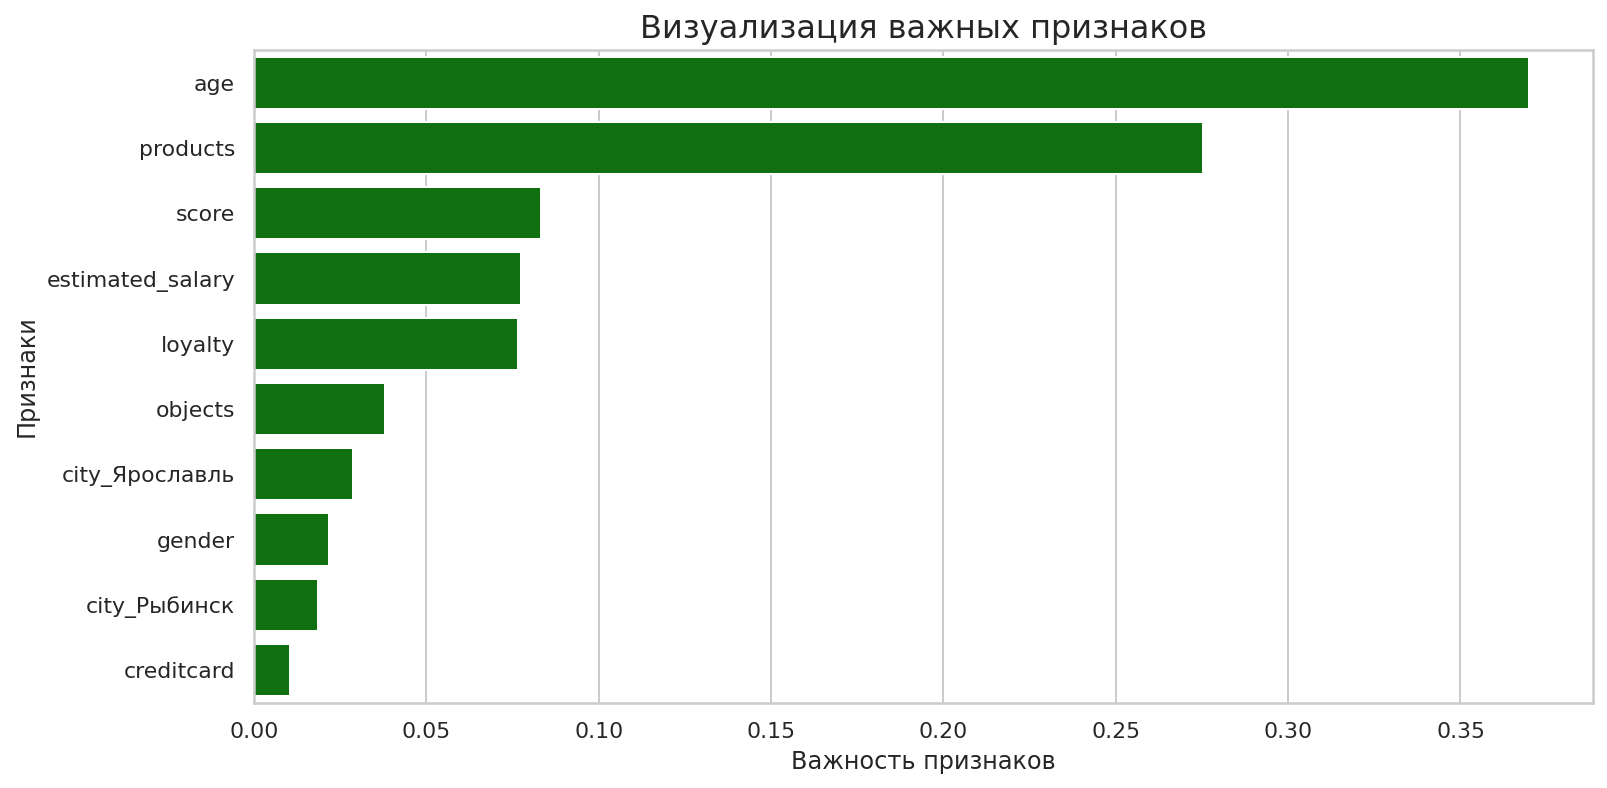

None

,features,gini_importance
0,age,0.37
1,products,0.28
2,score,0.08
3,estimated_salary,0.08
4,loyalty,0.08


In [77]:
# расчет значений признаков и их важность
feats = {}
for feature, importance in zip(X.columns, rf_model.feature_importances_):
    feats[feature] = importance

    
importances = pd.DataFrame.from_dict(feats, orient='index')\
                          .rename(columns={0: 'gini_importance'})
importances = importances.sort_values(by='gini_importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'features'})

# построение графика
sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(12,6))
sns.barplot(x=importances['gini_importance'], y=importances['features'],\
            data=importances, color='green')
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title('Визуализация важных признаков', fontsize=16)
display(plt.show())

# вывод таблицы 
display(importances.head());

Модель вычислила, что самым важным признаком в наборе является возраст. Далее идут количество банковских продуктов, баланс счета, кредитный скоринг, заработная плата.

Результаты похожи на те, что у нас получились на этапе сегментации. Кроме влияния пола – модель придала ему небольшой вес.

### Вывод по шагу

На основании расчитанных метрик модель прогнозирует довольно низкий процент верных ответов – 85%.

Самым важным признаком в прогнозировании оттока по расчетам модели является возраст. Далее идут количество банковских продуктов, баланс счета, кредитный скоринг, заработная плата.

Показатель пола не входит в топ-5.

----

## Кластеризация пользователей


- Стандартизация данных
- Построение дендрограммы
- Обучение модели кластеризации
- Прогнозирование кластеров
- Составление портретов клиентов
- <s>Прогнозирование доли оттока кластеров</s>
- Сравнение результатов сегментации и кластеризации
- Вывод по шагу

### Стандартизация данных


In [78]:
# преобразуем набор данных нормализатором на датасете с целевой переменной
X_sc = scaler.fit_transform(df_ml)

### Построение дендрограммы

<div class="alert alert-block alert-info">
<b>Комментарий:</b> 
Чтобы не перегружать проект отрисовкой дендрограммы, сохранила ее в картинку ниже и закомментила код.
</div>

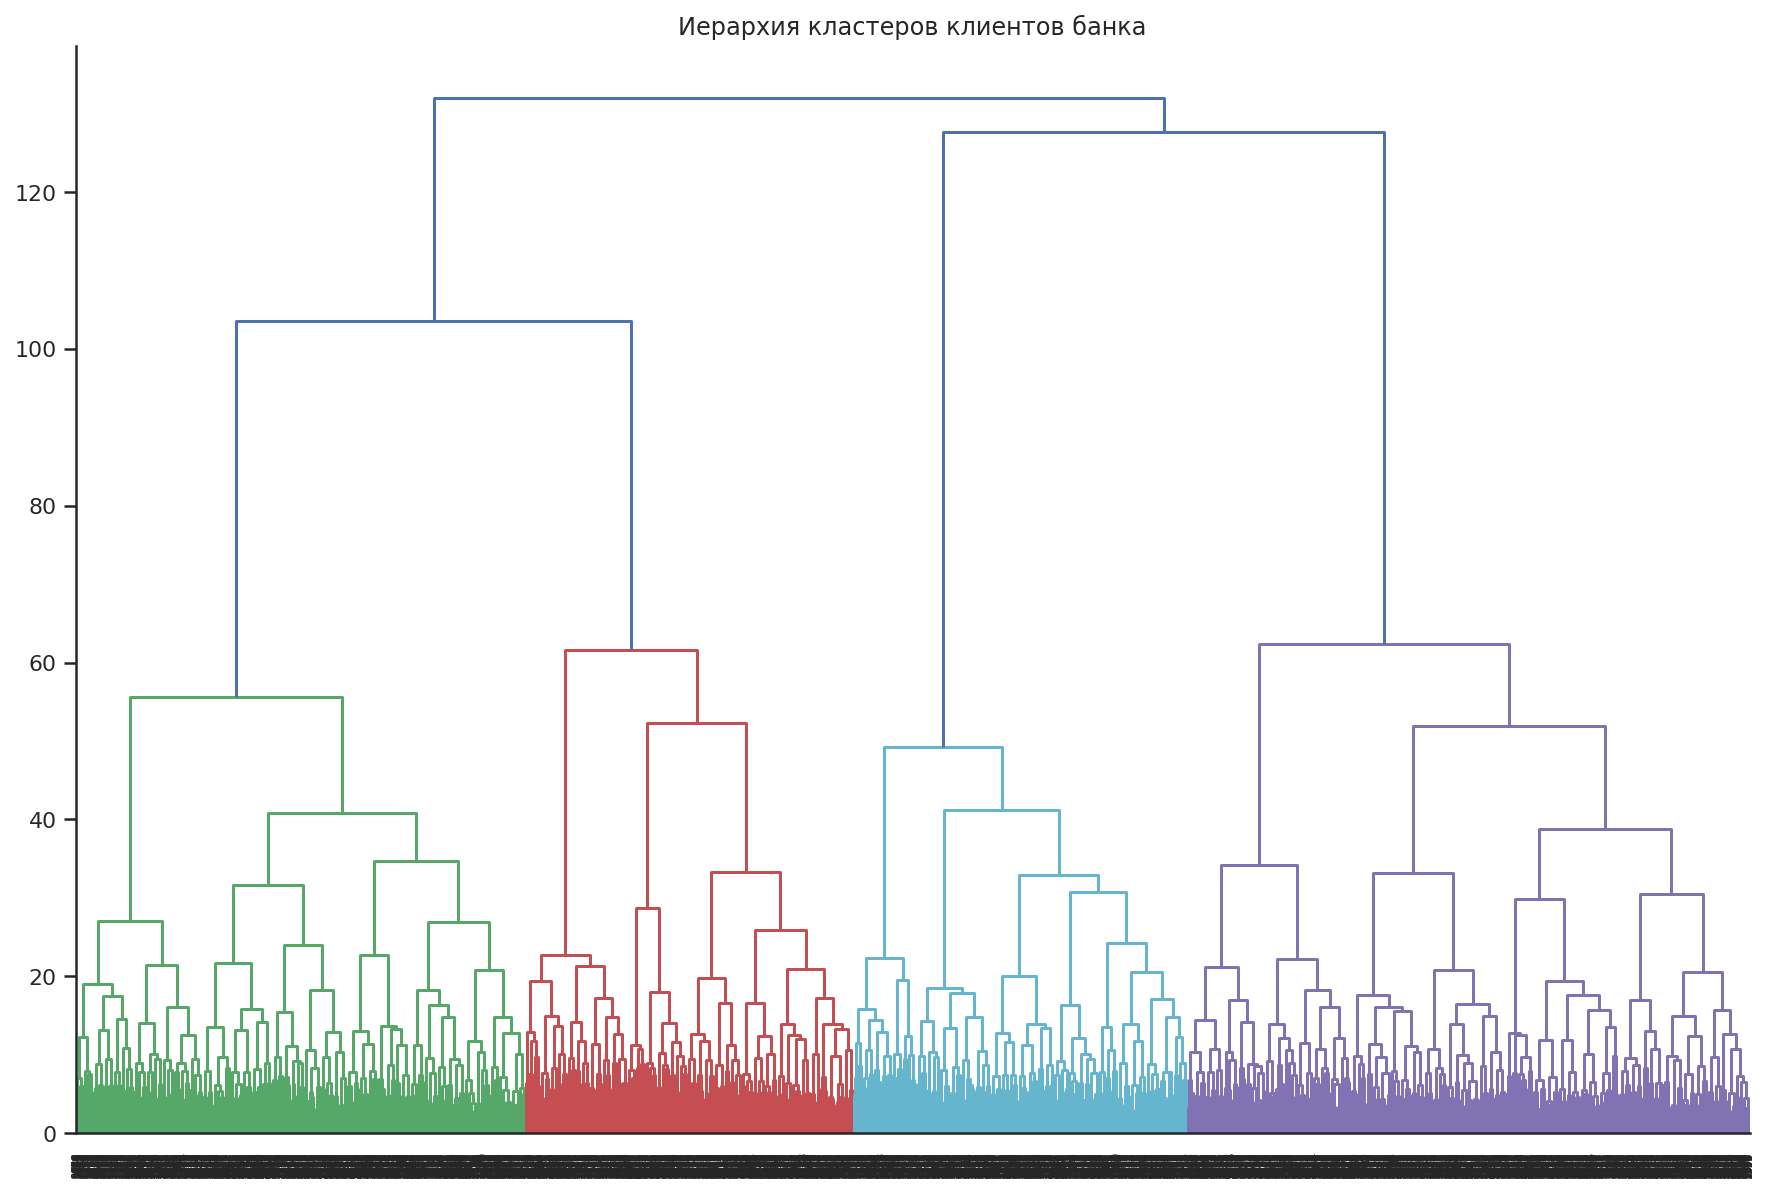

In [79]:
# сохраняем в переменной linked таблицу связок между объектами
'''linked = linkage(X_sc, method = 'ward')'''

"linked = linkage(X_sc, method = 'ward')"

In [80]:
# выведем дендрограмму
'''plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархия кластеров клиентов банка', fontsize=16)
plt.show();'''

"plt.figure(figsize=(15, 10))  \ndendrogram(linked, orientation='top')\nplt.title('Иерархия кластеров клиентов банка', fontsize=16)\nplt.show();"

При построении дендрограммы с учетом целевой переменной получаем число кластеров 4 (по цветам веток).

### Обучение модели кластеризации

In [81]:
# зададим модель k_means с числом кластеров 4
km = KMeans(n_clusters=4)

# спрогнозируем кластеры для наблюдений
labels = km.fit_predict(X_sc)

# сохраняем метки кластера в поле датасета
ml_clusters = df_ml
ml_clusters['cluster'] = labels

# посчитаем метрику силуэта для нашей кластеризации
print('Silhouette_score: {:.2f}'.format(silhouette_score(X_sc, labels)))

Silhouette_score: 0.12


Метрика силуэта получается не очень высокая, кластеры накладываются друг на друга. Но для наших задач это подходит, так как сегменты уже определены ранее и ML мы используем скорее для проверки.

### Прогнозирование кластеров

Используем алгоритм K-Means и спрогнозируем кластеры клиентов.

In [82]:
# выводим статистику по средним значениям наших признаков по кластеру
ml_clusters.groupby('cluster').mean().T

cluster,0,1,2,3
score,648.92,654.01,652.09,645.38
gender,0.56,0.57,0.59,0.44
age,35.36,38.76,37.71,45.16
objects,5.11,4.92,5.11,4.93
products,1.54,1.55,1.55,1.46
creditcard,0.71,0.71,0.70,0.70
loyalty,0.00,1.00,0.57,0.35
estimated_salary,101100.06,99385.00,98460.82,101604.48
churn,0.00,0.00,0.02,1.00
city_Рыбинск,0.00,0.00,1.00,0.19


Выделено 4 кластера, из которых можно составить как миниму 2 портрета – с риском оттока и без риска.


### Составление портретов по кластерам


Видим, что выделился кластер с нужной нам целевой переменной – вероятным числом оттока равным 1.

Вот **портрет клиента, склонного к оттоку**:

- скорее женщина
- средний возраст 45
- 36% активность
- город – вероятнее всего Ростов Великий



Также среди кластеров обнаружился **портрет клиента, вероятно не склонного к оттоку**:

- скорее мужчина
- средний возраст 37
- 55% активность
- город – вероятнее всего Ярославль

### Сравнение результатов сегментации и кластеризации

Сравним результаты кластеризации с оценкой по средним показателям.

Ранее мы рассчитывали средние показатели для двух групп - тех, кто остался и тех, кто ушёл в отток. Сравним их с результатами, полученными после кластеризации.


In [83]:
# сохраним номер кластера с оттоком в переменную
churn_cluster = max(
    map(
        lambda x: x if round(ml_clusters.groupby('cluster').agg('mean')\
                             .loc[x, 'churn'].mean()) == 1 else -1,
        ml_clusters['cluster'].unique()
    )
)

# создадим сводную таблицу с показателями
churn_final = df.pivot_table(
    index='churn',
    aggfunc='mean'
).T.apply(
    lambda s: s.apply('{0:.2f}'.format)
).reset_index().rename(
    columns = {
        'index':'feature',
        1:'by_mean'
    }
).merge(
    ml_clusters.loc[
        :,
        ml_clusters.columns != 'churn'
    ].groupby('cluster').agg('mean').T.apply(
        lambda s: s.apply('{0:.2f}'.format)
    ).reset_index().rename(
        columns = {
            'index':'feature',
            churn_cluster:'by_cluster'
        }
    ),
    on='feature'
)[['feature', 'by_mean', 'by_cluster']]


# поменяем типы данных
churn_final['by_mean'] = pd.to_numeric(churn_final['by_mean'])
churn_final['by_cluster'] = pd.to_numeric(churn_final['by_cluster'])


# рассчитаем относительную разницу
churn_final['difference'] = round(
    (1 - churn_final['by_mean'] / churn_final['by_cluster']) * 100,
    2
)

churn_final

,feature,by_mean,by_cluster,difference
0,age,44.84,45.16,0.71
1,creditcard,0.70,0.70,0.00
2,estimated_salary,101465.68,101604.48,0.14
3,gender,0.44,0.44,0.00
4,loyalty,0.36,0.35,-2.86
5,objects,4.93,4.93,0.00
6,products,1.48,1.46,-1.37
7,score,645.35,645.38,0.00


### Вывод по шагу

Практически по всем показателям кластеризация дала те же самые результаты, что и расчёт средних. 

Можно сделать вывод, что портрет клиента, склонного к оттоку выявлен точно.

----

## Итоги исследования


- Итоги исследования и рекомендации
- Ссылка на презентацию
- Ссылка на дашборд

### Итоги 

##### **Портрет среднестатистического клиента банка:**

- кредитный рейтинг 652 ("хороший")
- мужчина (55% клиентов)
- 37 лет
- 5 объектов в собственности
- 97000 уе на балансе
- 1 банковский продукт (1.52 в среднем)
- 71% имеет кредитную карту
- активен (50%)
- заработная плата 100000 уе
- 20% оттока

**Признаки, коррелирующие с оттоком:**
- пол
- возраст
- активность
- количество банковских продуктов
- город

**Признаки, практически не влияющие на отток:**
- баланс счета
- кредитный рейтинг
- средняя расчетная заработная плата
- количество объектов в собственности
- наличие кредитной карты


**Общий портрет клиента, который склонен покинуть банк:**
- Чаще всего женщина
- Возраст 44 года
- Использует 1 банковский продукт
- Не активен
- Клиент отделения в Ярославле или Ростове Великом

**Выделены портреты клиентов, у которых отток выше 39%**:

- Женщины 45+ с 1 продуктом
- Возраст 51-56
- Пользователи 3 и 4 продуктов
- Клиенты из Ростова Великого 45+


### Рекомендации

- в Ростове Великом в процент оттока выше среднего попадают даже клиенты младше 25. Вероятно, в этом банке нужно обратить внимание на провеку качества обслуживания, так как такое поведение не свойственно для других городов. Особое внимание стоит уделить клиентам-женщинам старше 44 лет в городе Ростов Великий, это самая рисковая группа, склонная к оттоку;

- в Ярославле в группу с оттоком попадают клиенты с балансом чуть выше среднего, при этом он больше, чем в группе без оттока. Предположительно, клиенты из Ярославля могут ожидать премиального обслуживания, имея баланс счета выше среднего, не получая его – уходят в отток;

- в Рыбинске в группе оттока клиентов с кредитными картами на 5% меньше, чем в среднем по базе, а сам отток на 2% меньше среднего по базе. Возможно, что в этом городе могут уходить люди из-за невозможности открыть кредитную карту, эту информацию нужно проверить менеджерам;

- особый пик оттока (более 50%) приходится на диапазон женщин возраста 51-56. Менеджерам следует изучить этот сегмент, чтобы выделить опасения и пожелания группы;

- в группе пенсионеров встречаются в подавляющем большинстве женщины. Обратите внимание на пенсионерок от 62 лет. Высокие показатели рсика говорят о том, что, вероятно, в период перед пенсией женщины начинают разбираться со своими банковскими счетами и продуктами, увеличивают активность и ищут выгодные предложения. Нужны программы лояльности для женщин старше 62 (пенсионерок);

- Для таргетированной рекламы лучше всего подходят клиенты, подходящие под типаж «идеальных»: мужчины около 37 лет;
- В датасете найдено 9 восемнадцатилетних клиентов с подозрительно высокими кредитными рейтингами: по закону кредиты можно брать с 18 лет, то есть у них пока не может быть кредитной истории, тем более с таким высоким рейтингом. Рекомендуется отдельно проверить данные по этим клиентам, вероятно есть ошибка;

- 221 клиент имеет очень хороший кредитный рейтинг, при этом рассчетную заработную плату менее 15000 уе. Если речь идет о рублях, то это ниже МРОТ. Сомнительно, что клиент может получить высокий балл рейтинга при таких доходах. Рекомендуется проверить данные по этим клиентам;

- В датасете присутствует более 3600 строк с отсутствующими данными о балансе. В эту группу входят только клиенты из Рыбинска и Ярославля, исключая Ростов Великий. Вероятно это техническая ошибка, стоит проверить данные;

- У неактивных клиентов отток почти в 2 раза больше. Беспокоит и то, неактивных клиентов в банке почти столько же, как активных. Стоит обратить внимание отдела работы с клиентами на этот показатель;

- У клиентов с 2 банковскими продуктами процент оттока ниже, стоит стимулировать клиентов пользоваться более чем одним продуктом.

Презентация (726 Кб, PDF): https://disk.yandex.ru/d/dzywYNo2VoWGOg